# Proyectos de Infraestructura Vial - MinObras

El Ministerio de Transporte (MinTransporte) cuenta con un presupuesto de **100 millones de pesos** para ejecutar obras de infraestructura vial, con el fin de generar desarrollo en el país.

MinTransporte le va a proporcionar datos que contiene información sobre:

- **Costo de ejecución** de cada proyecto (en millones de pesos)
- **Número de empleos generados** (en miles)
- **Ubicación geográfica** del proyecto (latitud y longitud)

El objetivo del Ministerio es **maximizar la cantidad total de empleos generados**, respetando el límite presupuestal.

## Datos

Generamos un conjunto artificial de datos para simular un portafolio de obras públicas, distribuidas geográficamente en cinco ciudades de Colombia:

- Bogotá
- Medellín
- Cartagena
- Barranquilla
- Cali

**Atributos generados**:

- **Ciudad**: selección aleatoria entre las 5 ciudades.
- **Costo de ejecución**: entre 0.001 y 10 millones de pesos.
- **# de empleos generados**: entre 0.01 y 15 mil.
- **Latitud y longitud**: aleatoria dentro de un rango representativo por ciudad.

In [1]:
import time
import sys
import os

# ============================================================================
# Preparación del entorno y carga de datos
# ============================================================================
# Este script importa y genera instancias para el problema de la mochila
# utilizando una fuente externa ('InsKnapsack.py') ubicada en un directorio
# de instancias personalizado.
# ============================================================================

# --------------------------------------------------------------------------
# 1. AJUSTAR EL PATH PARA ACCEDER A INSTANCIAS PERSONALIZADAS
# --------------------------------------------------------------------------
# Agrega la ruta '../Instances' al path para importar desde allí
sys.path.append(os.path.abspath("../Instances"))

# --------------------------------------------------------------------------
# 2. IMPORTAR Y GENERAR LOS DATOS DE PRUEBA
# --------------------------------------------------------------------------
from InsKnapsack import generar_datos

# Generar un conjunto de'n' "obras" (ítems) con beneficios y pesos
obras = generar_datos(15)

# --------------------------------------------------------------------------
# 3. PREPARAR ESTRUCTURA PARA ALMACENAR RESULTADOS
# --------------------------------------------------------------------------
resultados = []  # lista donde se irán guardando salidas de algoritmos

# --------------------------------------------------------------------------
# 4. MOSTRAR DATOS GENERADOS (opcional)
# --------------------------------------------------------------------------
obras


,Ciudad,Costo de ejecución (en millones de pesos),# de empleos generados (en miles),Latitud,Longitud
0,Cali,4.0,11.0,3.414580,-76.539294
1,Barranquilla,3.0,2.0,10.935737,-74.710802
2,Cartagena,3.0,11.0,10.375788,-75.496888
3,Bogotá,10.0,12.0,4.817227,-74.108449
4,Cartagena,4.0,14.0,10.321948,-75.558864
5,Cartagena,7.0,4.0,10.423973,-75.521297
6,Cali,1.0,10.0,3.358204,-76.567876
7,Bogotá,6.0,9.0,4.561431,-74.044600
8,Medellín,10.0,1.0,6.309026,-75.535126
9,Bogotá,9.0,4.0,4.645661,-74.181615


## Optimización (MIP)

### Formulación

#### 1. Conjuntos  
$O$: conjunto de obras disponibles.

#### 2. Parámetros  
$c_i$: costo de ejecución (en millones de pesos) de la obra $i \in O$  
$e_i$: empleos generados (en miles) por la realización de la obra $i \in O$  
$p$: presupuesto total disponible (en millones de pesos)

#### 3. Variables de decisión  
$$
x_i =
\begin{cases}
1, & \text{si la obra } i \in O \text{ se lleva a cabo} \\
0, & \text{en caso contrario}
\end{cases}
$$

#### 4. Función objetivo  
Maximizar el total de empleos generados:
$$
\max \sum_{i \in O} e_i \cdot x_i
$$

#### 5. Restricciones  

**(1) Presupuesto disponible:**  
$$
\sum_{i \in O} c_i \cdot x_i \leq p
$$

**(2) Naturaleza de las variables:**  
$$
x_i \in \{0, 1\}, \quad \forall i \in O
$$

Donde:

- La restricción (1) garantiza que no se exceda el presupuesto disponible.  
- La restricción (2) establece la naturaleza binaria de las variables de decisión.


In [2]:
# ============================================================================
# Parametrización del problema: selección de obras bajo restricción presupuestal
# ============================================================================
# Se extraen los parámetros relevantes desde el DataFrame 'obras' para
# construir los insumos del modelo:
#   • Conjunto de decisiones
#   • Costos (c)
#   • Beneficios (empleos generados, e)
#   • Información geográfica (lat, log)
#   • Presupuesto total disponible
# ============================================================================

# --------------------------------------------------------------------------
# 1. CONJUNTO DE ÍTEMS (obras disponibles)
# --------------------------------------------------------------------------
O = list(obras.index)  # Lista de identificadores de obras (índices del DataFrame)

# --------------------------------------------------------------------------
# 2. PARÁMETROS DE CADA OBRA
# --------------------------------------------------------------------------

# ▸ c[o] : costo de ejecutar la obra o (en millones de COP)
c = dict(obras['Costo de ejecución (en millones de pesos)'].squeeze())

# ▸ e[o] : empleos generados por la obra o (en miles de personas)
e = dict(obras['# de empleos generados (en miles)'].squeeze())

# ▸ lat[o], log[o] : coordenadas geográficas de la obra o
lat = dict(obras['Latitud'].squeeze())   # latitud para visualización
log = dict(obras['Longitud'].squeeze())  # longitud para visualización

# --------------------------------------------------------------------------
# 3. RESTRICCIÓN PRESUPUESTAL
# --------------------------------------------------------------------------
# Presupuesto disponible en millones de COP (valor flexible)
# Aquí se fija como el mínimo entre:
#    ▸ número de obras
#    ▸ 100 millones
p = min(len(O), 100)


### Modelo

In [3]:
import pulp as lp

def optimizacion_knapsack(O, c, e, p):
    """
    ============================================================================
    Optimización tipo mochila (knapsack binaria) para selección de obras públicas
    ─────────────────────────────────────────────────────────────────────────────
    Objetivo:
      • Seleccionar un subconjunto de obras que **maximice la generación de empleo**
        bajo un presupuesto máximo disponible.

    Entradas
      • O : list
            Conjunto de identificadores de obras (ítems disponibles)
      • c : dict[obra → costo]
            Costo de ejecutar cada obra (en millones de COP)
      • e : dict[obra → empleos]
            Empleos generados por cada obra (en miles)
      • p : float
            Presupuesto total disponible (en millones de COP)

    Salida
      • model               : objeto del modelo PuLP (útil para trazabilidad)
      • x                  : dict[obra → variable binaria] con solución óptima
    ============================================================================

    Descripción resumida
    ---------------------------------------------------------------------------
      ▸ Modelo binario con función objetivo lineal:
              max   ∑ e[i]·x[i]
              s.a.  ∑ c[i]·x[i] ≤ p
                     x[i] ∈ {0,1}
      ▸ Se resuelve usando el solver por defecto de PuLP (CBC)
    """

    # -------------------------------------------------------------------------
    # 1. DEFINICIÓN DEL MODELO DE OPTIMIZACIÓN
    # -------------------------------------------------------------------------
    model = lp.LpProblem("Obras", lp.LpMaximize)

    # -------------------------------------------------------------------------
    # 2. VARIABLES DE DECISIÓN: x[i] = 1 si se selecciona la obra i
    # -------------------------------------------------------------------------
    x = {i: lp.LpVariable(f'x_{i}', lowBound=0, cat=lp.LpBinary) for i in O}

    # -------------------------------------------------------------------------
    # 3. FUNCIÓN OBJETIVO: maximizar empleos generados
    # -------------------------------------------------------------------------
    model += lp.lpSum(e[i] * x[i] for i in O)

    # -------------------------------------------------------------------------
    # 4. RESTRICCIONES
    # -------------------------------------------------------------------------

    # ▸ Presupuesto total no debe exceder p
    model += lp.lpSum(c[i] * x[i] for i in O) <= p

    # ▸ Restricción de binariedad ya está impuesta al definir las variables

    # -------------------------------------------------------------------------
    # 5. RESOLVER EL MODELO (usando CBC Solver)
    # -------------------------------------------------------------------------
    solver = lp.getSolver('PULP_CBC_CMD', msg=False)
    model.solve(solver)

    # -------------------------------------------------------------------------
    # 6. REPORTE DEL ESTADO DE SOLUCIÓN
    # -------------------------------------------------------------------------
    print(f'El optimizador llegó a una solución: {lp.LpStatus[model.status]}.')

    return model, x


In [4]:
# ============================================================================
# Ejecución y evaluación del modelo LP (mochila binaria con PuLP)
# ============================================================================
# Se mide el tiempo de ejecución, se extraen resultados relevantes y se
# almacenan en una lista de reportes para análisis posterior.
# ============================================================================

# --------------------------------------------------------------------------
# 1. MEDIR TIEMPO DE EJECUCIÓN
# --------------------------------------------------------------------------
start = time.perf_counter()

# ▸ Ejecutar el modelo exacto
model, x = optimizacion_knapsack(O, c, e, p)

end = time.perf_counter()

# --------------------------------------------------------------------------
# 2. EXTRACCIÓN DE RESULTADOS DE LA SOLUCIÓN
# --------------------------------------------------------------------------

# ▸ Valor óptimo de la función objetivo (empleos generados)
obj_lp = round(lp.value(model.objective), 3)

# ▸ Lista de obras seleccionadas según x[i] = 1
obras_selec_lp = [i for i in O if x[i].varValue == 1]

# ▸ Presupuesto total utilizado (suma de los costos seleccionados)
presupuesto_usado_lp = round(sum(c[i] for i in obras_selec_lp), 2)

# --------------------------------------------------------------------------
# 3. REPORTE POR CONSOLA
# --------------------------------------------------------------------------
print(f'FO (valor total): {obj_lp}')
print(f'Cantidad de obras seleccionadas: {len(obras_selec_lp)}.')
print(f'Presupuesto usado: {presupuesto_usado_lp}/{p}')
print(f"Tiempo (s): {end - start:.8f}")

# --------------------------------------------------------------------------
# 4. ALMACENAR RESULTADOS EN LISTA DE REPORTES
# --------------------------------------------------------------------------
resultados.append({
    "Método"             : "LP",
    "Empleos generados"  : obj_lp,
    "Obras seleccionadas": len(obras_selec_lp),
    "Presupuesto usado"  : presupuesto_usado_lp,
    "Tiempo (s)"         : end - start
})


El optimizador llegó a una solución: Optimal.
FO (valor total): 64.0
Cantidad de obras seleccionadas: 5.
Presupuesto usado: 15.0/15
Tiempo (s): 0.08563967


## Programación Dinámica

### Teoría

#### 1. ¿Qué es la Programación Dinámica?

La Programación Dinámica (PD) es una familia de métodos usados para resolver procesos de decisión secuenciales. PD se aplica cuando se conoce completamente el modelo del entorno, es decir:

- Las probabilidades de transición: $P(s' \mid s, a)$
- Las recompensas esperadas: $R(s, a, s')$

El objetivo es encontrar una política que maximice la recompensa acumulada esperada. Esto se hace resolviendo recursivamente las **ecuaciones de Bellman**.

#### 2. Componentes

Un problema secuencial se modela como un **Proceso de Decisión de Markov (MDP)** con:

- $S$: conjunto de estados.
- $A$: conjunto de acciones.
- $P(s' \mid s, a)$: probabilidad de transitar a $s'$ desde $s$ al tomar $a$.
- $R(s, a, s')$: recompensa esperada al ir de $s$ a $s'$ con acción $a$.
- $\gamma$: factor de descuento $(0 \leq \gamma \leq 1)$ que pondera recompensas futuras.

#### 3. Funciones de Valor

$v_\pi(s)$ es la recompensa esperada al seguir la política $\pi$ desde el estado $s$:

$$
v_\pi(s) = \mathbb{E}_\pi \left[ \sum_{t=0}^\infty \gamma^t R_{t+1} \mid S_0 = s \right]
$$

Ecuación de Bellman para $v_\pi$:

$$
v_\pi(s) = \sum_a \pi(a \mid s) \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma v_\pi(s') \right]
$$

#### 4. Objetivo: encontrar la política óptima

Queremos encontrar una política $\pi^*$ tal que:

$$
v_{\pi^*}(s) \geq v_\pi(s), \quad \text{para todo } s \text{ y para toda } \pi
$$

La función de valor óptima $v_*$ satisface la **ecuación de Bellman óptima**:

$$
v_*(s) = \max_a \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma v_*(s') \right]
$$

### Algoritmos de Solución

| **Símbolo** | **Definición (problema _knapsack_)** | **Comentarios** |
|-------------|--------------------------------------|-----------------|
| **Estados $\mathcal{S}$** | Par ordenado $s=(i,c)$ donde:<br>• $i \in \{0,\dots,n\}$ es el índice del **próximo** objeto por decidir.<br>• $c \in \{0,\dots,W\}$ es la **capacidad restante**. | Esta representación mantiene la información necesaria: cuántos ítems quedan por evaluar y cuánta capacidad nos queda. |
| **Acciones $\mathcal{A}(s)$** | Para $i < n$:<br>• **Tomar** el objeto $i$ (solo si $w_i \le c$).<br>• **Omitir** el objeto $i$.<br>Para $i = n$ no hay acciones (estado terminal). | Con “tomar” avanzamos al siguiente objeto y restamos su peso; con “omitir” solo avanzamos. |
| **Transición $p(s',r \mid s,a)$** | **Determinista**: al elegir acción $a$ desde $(i,c)$:<br>– Si **tomar**: $s' = (i+1,\,c-w_i)$, recompensa $r = v_i$.<br>– Si **omitir**: $s' = (i+1,\,c)$, recompensa $r = 0$. | No hay azar; todos los caminos están completamente determinados. |
| **Recompensa $\mathcal{R}(s,a)$** | Valor inmediato del objeto si se toma; $0$ si se omite. | La **suma total de recompensas** a lo largo del episodio es exactamente el valor acumulado de la mochila. |
| **Factor de descuento $\gamma$** | $\gamma = 1$ | El episodio es finito (máx. $n$ decisiones) y no nos preocupa preferir valor temprano o tardío. |
| **Distribución inicial $p_0(s)$** | Único estado inicial $s_0 = (0,W)$. | Al empezar, contamos con cero objetos seleccionados y la totalidad de la capacidad. |
| **Estados terminales $\mathcal{T}$** | Todos los estados con $i = n$. | Una vez evaluados los $n$ objetos ya no hay más decisiones; el episodio termina. |

In [5]:
# ============================================================================
# Importación de módulos del proyecto: entorno, algoritmos y visualización
# ============================================================================
# Se agregan las rutas correspondientes al entorno del problema de mochila,
# las implementaciones de algoritmos de optimización dinámica y funciones
# de visualización asociadas.
# ============================================================================

# --------------------------------------------------------------------------
# 1. AJUSTAR RUTAS AL PROYECTO (para imports relativos personalizados)
# --------------------------------------------------------------------------
sys.path.append(os.path.abspath("../DP/Env"))         # entorno del problema
sys.path.append(os.path.abspath("../DP/Algorithms/")) # algoritmos RL / DP
sys.path.append(os.path.abspath("../DP/Visual/"))     # visualización de políticas / valores

# --------------------------------------------------------------------------
# 2. IMPORTAR COMPONENTES DEL ENTORNO
# --------------------------------------------------------------------------
from Knapsack import KnapsackEnv  # Clase que define el entorno tipo mochila

# --------------------------------------------------------------------------
# 3. IMPORTAR ALGORITMOS DE CONTROL / VALORACIÓN
# --------------------------------------------------------------------------
from value_iteration import value_iteration           # iteración de valores
from policy_evaluation import policy_evaluation       # evaluación de políticas
from policy_iteration import policy_iteration         # iteración de políticas

# --------------------------------------------------------------------------
# 4. IMPORTAR FUNCIONES DE VISUALIZACIÓN
# --------------------------------------------------------------------------
from value_states import value_states_visual          # visualización de V(s)
from policy_dag import draw_policy_dag                # grafo de política óptima


#### Datos

In [6]:
# ============================================================================
# Creación del entorno KnapsackEnv para RL/DP
# ============================================================================
# Se instancia el entorno tipo mochila con pesos, valores y capacidad a partir
# de los datos originales de obras. Este entorno será usado por los algoritmos
# de iteración de valores y políticas.
# ============================================================================

# --------------------------------------------------------------------------
# 1. PARAMETRIZAR EL ENTORNO
# --------------------------------------------------------------------------

weights  = list(c.values())  # pesos de los ítems: costos (millones de COP)
values   = list(e.values())  # beneficios de los ítems: empleos (miles)
capacity = p                 # capacidad total: presupuesto disponible

# --------------------------------------------------------------------------
# 2. CREAR INSTANCIA DEL ENTORNO
# --------------------------------------------------------------------------
env = KnapsackEnv(weights, values, capacity)

# --------------------------------------------------------------------------
# 3. MOSTRAR INFORMACIÓN DEL ENTORNO
# --------------------------------------------------------------------------
print(env)  # resumen textual del entorno (definido por __str__ o __repr__)


KnapsackEnv(#_Objetos = 15, Capacidad = 15, #_Estados = 256)


#### Policy Evaluation

Este algoritmo calcula de forma iterativa el valor esperado de cada estado bajo una política dada $\pi$. El procedimiento estima la función de valor $V(s)$ para todos los estados $s \in \mathcal{S}$ hasta que la aproximación sea suficientemente precisa.

##### Entradas
- $\pi$: política fija que se desea evaluar
- $\mathcal{S}$: conjunto de todos los estados posibles
- $p(s', r \mid s, a)$: probabilidad de transición y recompensa al ejecutar la acción $a$ en el estado $s$
- $\gamma$: factor de descuento ($0 \leq \gamma < 1$)
- $\theta$: umbral de convergencia (pequeño número positivo)

##### Inicialización
- Se asigna $V(s) = 0$ para todo $s \in \mathcal{S}$

##### Algoritmo
Se repiten las siguientes actualizaciones hasta que los cambios en los valores de los estados sean menores que el umbral $\theta$:

1. Inicializar $\Delta \leftarrow 0$  
2. Para cada estado $s \in \mathcal{S}$:
    - Guardar el valor actual: $v \leftarrow V(s)$  
    - Actualizar $V(s)$ según la política $\pi$ y el modelo del entorno:  
      $$
      V(s) \leftarrow \sum_a \pi(a \mid s) \sum_{s', r} p(s', r \mid s, a)\,\left[ r + \gamma V(s') \right]
      $$
    - Actualizar la diferencia máxima:  
      $$
      \Delta \leftarrow \max\left(\Delta,\; |v - V(s)|\right)
      $$

3. Repetir hasta que $\Delta < \theta$

##### Salida
- Se retorna la función $V$ que aproxima el valor esperado de cada estado bajo la política $\pi$:  
  $$
  V \approx v_\pi
  $$

Este procedimiento garantiza la convergencia a $v_\pi$ si el espacio de estados es finito y $\gamma < 1$.


In [7]:
# ============================================================================
# Evaluación de una política heurística (greedy con 'take' si es legal)
# ============================================================================
# Se define una política inicial que toma cada ítem si es legal hacerlo.
# Luego, se evalúa su valor esperado (V) en todo el espacio de estados,
# y se reportan métricas similares al enfoque LP.
# ============================================================================

# --------------------------------------------------------------------------
# 1. DEFINIR POLÍTICA PROPUESTA: tomar si es posible
# --------------------------------------------------------------------------
# Cada estado s = (i, capacidad restante)
# Acción: 'take' si está permitida; si no, 'skip'
propose_policy = {
    s: ('take' if 'take' in env.actions(s) else 'skip')
    for s in env.state_space()
}

policy = propose_policy.copy()

# --------------------------------------------------------------------------
# 2. EVALUAR LA POLÍTICA (valor esperado en cada estado)
# --------------------------------------------------------------------------
t0 = time.perf_counter()

# ▸ Evaluación de la política determinista 'propose_policy'
V = policy_evaluation(env, propose_policy)

elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# --------------------------------------------------------------------------
# 3. REPORTAR RESULTADOS DESDE LA POLÍTICA EVALUADA
# --------------------------------------------------------------------------
# Método auxiliar del entorno: devuelve
#  - valor total (beneficio alcanzado)
#  - cantidad de objetos tomados
#  - peso total utilizado
valor_total, objetos_tomados, peso_total = env.report_from_policy(policy)

# --------------------------------------------------------------------------
# 4. ALMACENAR RESULTADOS EN LISTA DE REPORTES
# --------------------------------------------------------------------------
resultados.append({
    "Método"             : "Policy evaluation",
    "Empleos generados"  : round(valor_total, 3),
    "Obras seleccionadas": len(objetos_tomados),
    "Presupuesto usado"  : round(peso_total, 2),
    "Tiempo (s)"         : elapsed
})



Tiempo de ejecución: 0.002304 s
Objetos seleccionados:
  • Obj  0: peso=4.0, valor=11.0
  • Obj  1: peso=3.0, valor=2.0
  • Obj  2: peso=3.0, valor=11.0
  • Obj  4: peso=4.0, valor=14.0
  • Obj  6: peso=1.0, valor=10.0
FO (valor total):    48.0
Presupuesto usado:   15.0/15


#### Policy Iteration

El siguiente algoritmo encuentra una política óptima en un problema de decisión de Markov (MDP) resolviendo iterativamente dos etapas: **evaluación de política** y **mejora de política**. La política y la función de valor se actualizan hasta que la política deje de cambiar.

##### Entradas
- $\mathcal{S}$: conjunto de estados
- $\mathcal{A}(s)$: conjunto de acciones disponibles en cada estado $s$
- $p(s', r \mid s, a)$: probabilidad de transición y recompensa
- $\gamma$: factor de descuento
- $\theta$: umbral de convergencia para la evaluación de política

##### 1. Inicialización**
Asignar de manera arbitraria:
- Una política inicial $\pi(s) \in \mathcal{A}(s)$  
- Una función de valor $V(s) \in \mathbb{R}$ para todo $s \in \mathcal{S}$

##### 2. Evaluación de la política**
Repetir hasta convergencia:

1. Inicializar $\Delta \leftarrow 0$  
2. Para cada estado $s \in \mathcal{S}$:  
   - Guardar el valor actual: $v \leftarrow V(s)$  
   - Actualizar según la política actual:  
     $$
     V(s) \leftarrow \sum_{s', r} p(s', r \mid s, \pi(s)) \left[ r + \gamma V(s') \right]
     $$
   - Actualizar el cambio máximo:  
     $$
     \Delta \leftarrow \max(\Delta,\; |v - V(s)|)
     $$

Finalizar cuando $\Delta < \theta$

##### 3. Mejora de la política**
1. Inicializar: $policy\text{-}stable \leftarrow \text{true}$  
2. Para cada estado $s \in \mathcal{S}$:  
   - Almacenar la acción actual: $a \leftarrow \pi(s)$  
   - Actualizar la política eligiendo la mejor acción según $V$:  
     $$
     \pi(s) \leftarrow \arg\max_a \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma V(s') \right]
     $$
   - Si $a \ne \pi(s)$ entonces:  
     $policy\text{-}stable \leftarrow \text{false}$

##### 4. Verificación de convergencia**
- Si $policy\text{-}stable$ es verdadero:  
  Detener y retornar $(V, \pi)$  
- De lo contrario: volver a la etapa de evaluación de política (paso 2)


In [8]:
# ============================================================================
# Aplicación del algoritmo de Iteración de Políticas (policy_iteration)
# ============================================================================
# Se parte de una política inicial (`policy`) y se itera entre evaluación y mejora
# hasta alcanzar una política óptima. Luego se mide su rendimiento.
# ============================================================================

# --------------------------------------------------------------------------
# 1. EJECUTAR POLICY ITERATION
# --------------------------------------------------------------------------
t0 = time.perf_counter()

# ▸ Aplicar iteración de políticas sobre el entorno de mochila
star_policy, V_star = policy_iteration(env, policy)

elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# --------------------------------------------------------------------------
# 2. EVALUAR LA POLÍTICA ÓPTIMA OBTENIDA
# --------------------------------------------------------------------------
valor_total, objetos_tomados, peso_total = env.report_from_policy(star_policy)

# --------------------------------------------------------------------------
# 3. ALMACENAR RESULTADOS EN LISTA DE REPORTE
# --------------------------------------------------------------------------
resultados.append({
    "Método"             : "Policy iteration",
    "Empleos generados"  : round(valor_total, 3),
    "Obras seleccionadas": len(objetos_tomados),
    "Presupuesto usado"  : round(peso_total, 2),
    "Tiempo (s)"         : elapsed
})



Tiempo de ejecución: 0.009288 s
Objetos seleccionados:
  • Obj  4: peso=4.0, valor=14.0
  • Obj  6: peso=1.0, valor=10.0
  • Obj 10: peso=5.0, valor=13.0
  • Obj 11: peso=2.0, valor=14.0
  • Obj 13: peso=3.0, valor=13.0
FO (valor total):    64.0
Presupuesto usado:   15.0/15


#### Value Iteration

Este algoritmo aproxima de manera iterativa la función de valor óptima $V^*$ resolviendo la ecuación de Bellman de forma sucesiva. Una vez que la función de valor ha convergido, se extrae una política óptima $\pi^*$ de forma determinista.

##### Entradas
- $\mathcal{S}$: conjunto de estados
- $\mathcal{A}(s)$: conjunto de acciones disponibles en cada estado $s$
- $p(s', r \mid s, a)$: probabilidad de transición y recompensa al aplicar $a$ en $s$
- $\gamma$: factor de descuento ($0 \leq \gamma < 1$)
- $\theta$: umbral de convergencia

##### 1. Inicialización
Asignar arbitrariamente valores iniciales a la función $V$  
(por ejemplo: $V(s) = 0$ para todo $s \in \mathcal{S}$)

##### 2. Iteración de Bellman
Repetir:

1. Inicializar $\Delta \leftarrow 0$  
2. Para cada estado $s \in \mathcal{S}$:
   - Guardar el valor actual: $v \leftarrow V(s)$  
   - Actualizar el valor de $s$ usando la mejor acción posible:  
     $$
     V(s) \leftarrow \max_a \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma V(s') \right]
     $$
   - Actualizar la diferencia máxima:  
     $$
     \Delta \leftarrow \max\left( \Delta,\; |v - V(s)| \right)
     $$

Repetir hasta que $\Delta < \theta$

##### 3. Extracción de la política
Una vez que $V$ ha convergido, definir una política determinista $\pi$ como:
$$
\pi(s) = \arg\max_a \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma V(s') \right]
$$

##### Salida
- La función de valor $V$ aproximada  
- Una política determinista $\pi$ que es óptima con respecto a $V$


In [9]:
# ============================================================================
# Aplicación del algoritmo de Iteración de Valores (value_iteration)
# ============================================================================
# Calcula V* mediante actualización iterativa de valores de estado, luego
# deriva una política óptima π* de forma greedy respecto a V*.
# ============================================================================

# --------------------------------------------------------------------------
# 1. EJECUTAR VALUE ITERATION
# --------------------------------------------------------------------------
t0 = time.perf_counter()

# ▸ Ejecutar algoritmo de iteración de valores sobre el entorno
opt_policy, V_opt = value_iteration(env)

elapsed = time.perf_counter() - t0
print(f"\nTiempo de ejecución: {elapsed:.6f} s")

# --------------------------------------------------------------------------
# 2. EVALUAR LA POLÍTICA DERIVADA DE V*
# --------------------------------------------------------------------------
valor_total, objetos_tomados, peso_total = env.report_from_policy(opt_policy)

# --------------------------------------------------------------------------
# 3. ALMACENAR RESULTADOS EN LISTA DE REPORTE
# --------------------------------------------------------------------------
resultados.append({
    "Método"             : "Value iteration",
    "Empleos generados"  : round(valor_total, 3),
    "Obras seleccionadas": len(objetos_tomados),
    "Presupuesto usado"  : round(peso_total, 2),
    "Tiempo (s)"         : elapsed
})



Tiempo de ejecución: 0.005194 s
Objetos seleccionados:
  • Obj  4: peso=4.0, valor=14.0
  • Obj  6: peso=1.0, valor=10.0
  • Obj 10: peso=5.0, valor=13.0
  • Obj 11: peso=2.0, valor=14.0
  • Obj 13: peso=3.0, valor=13.0
FO (valor total):    64.0
Presupuesto usado:   15.0/15


### Visualización

#### Value Functions

Policy Evaluation


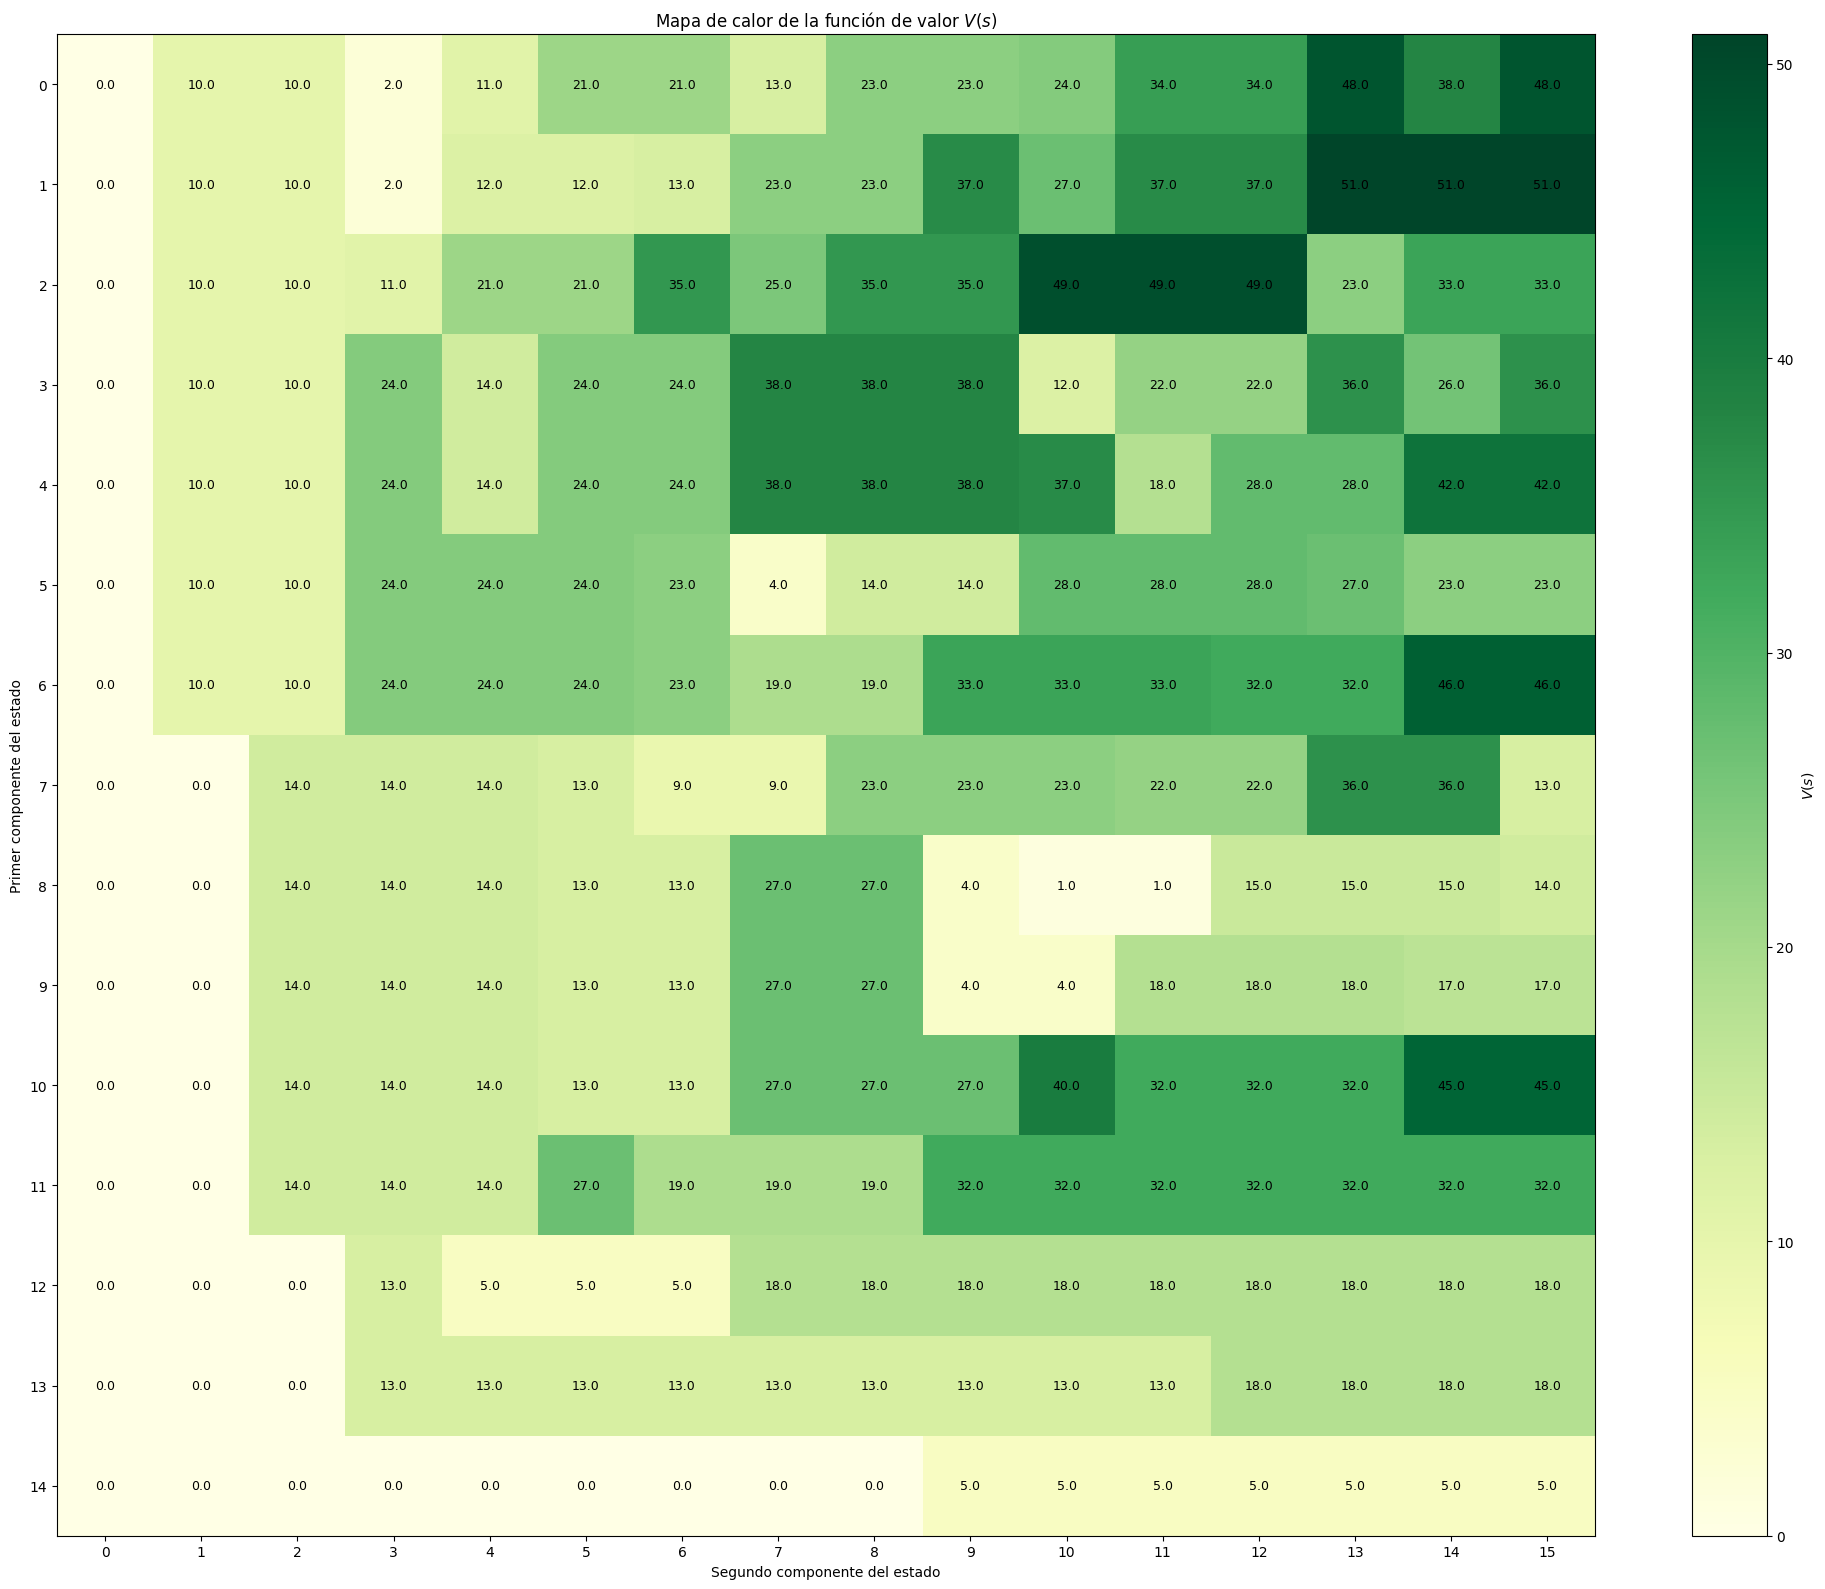


Policy Iteration


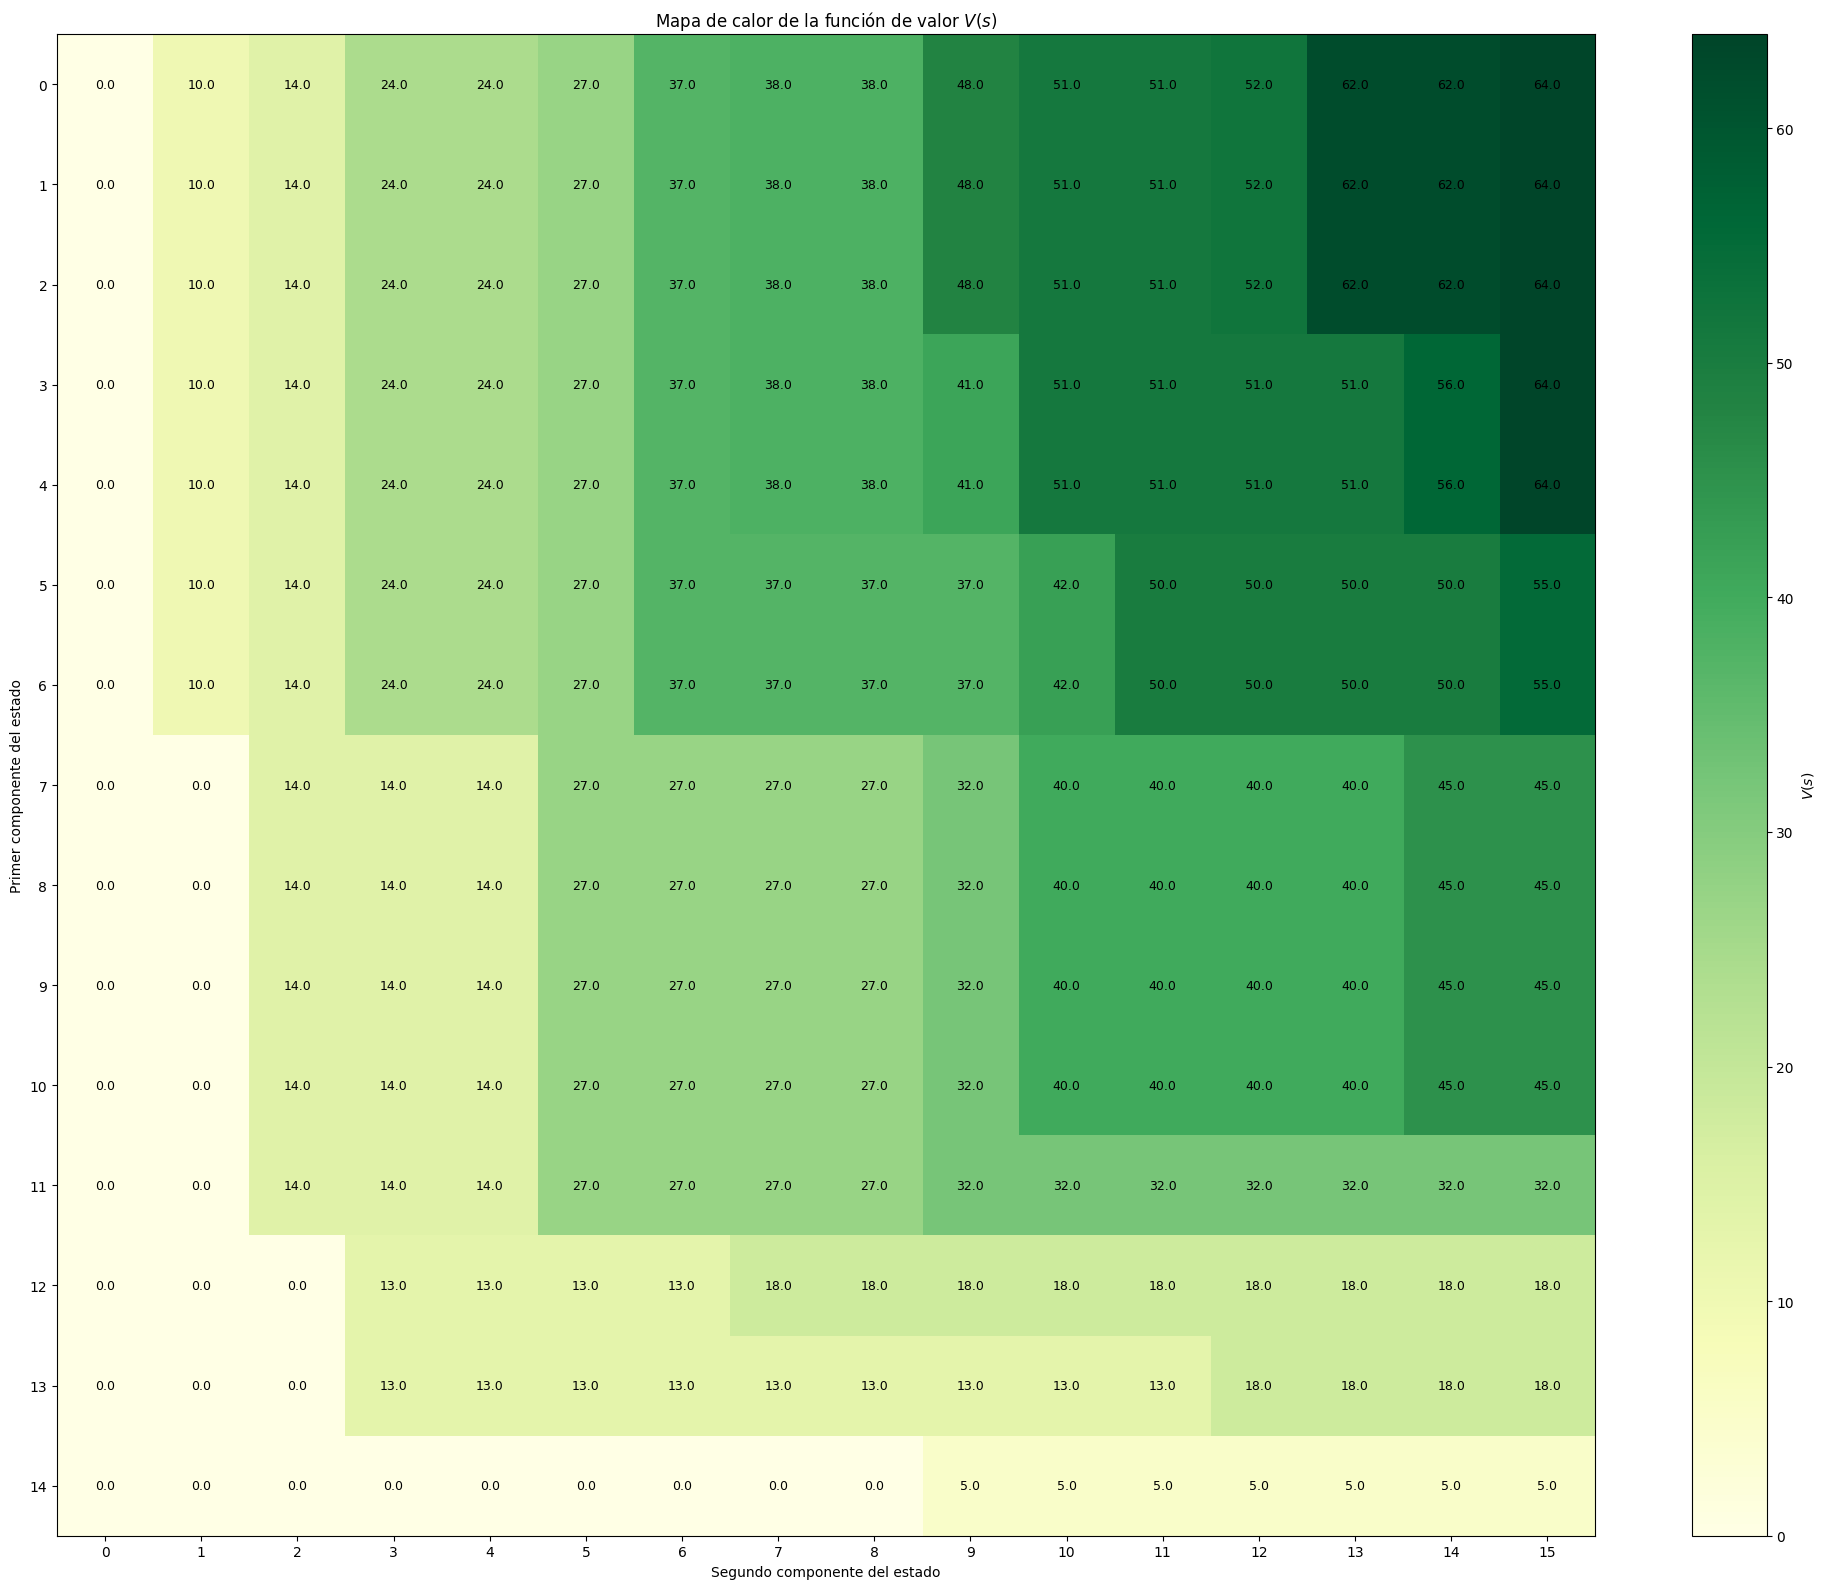


Value Iteration


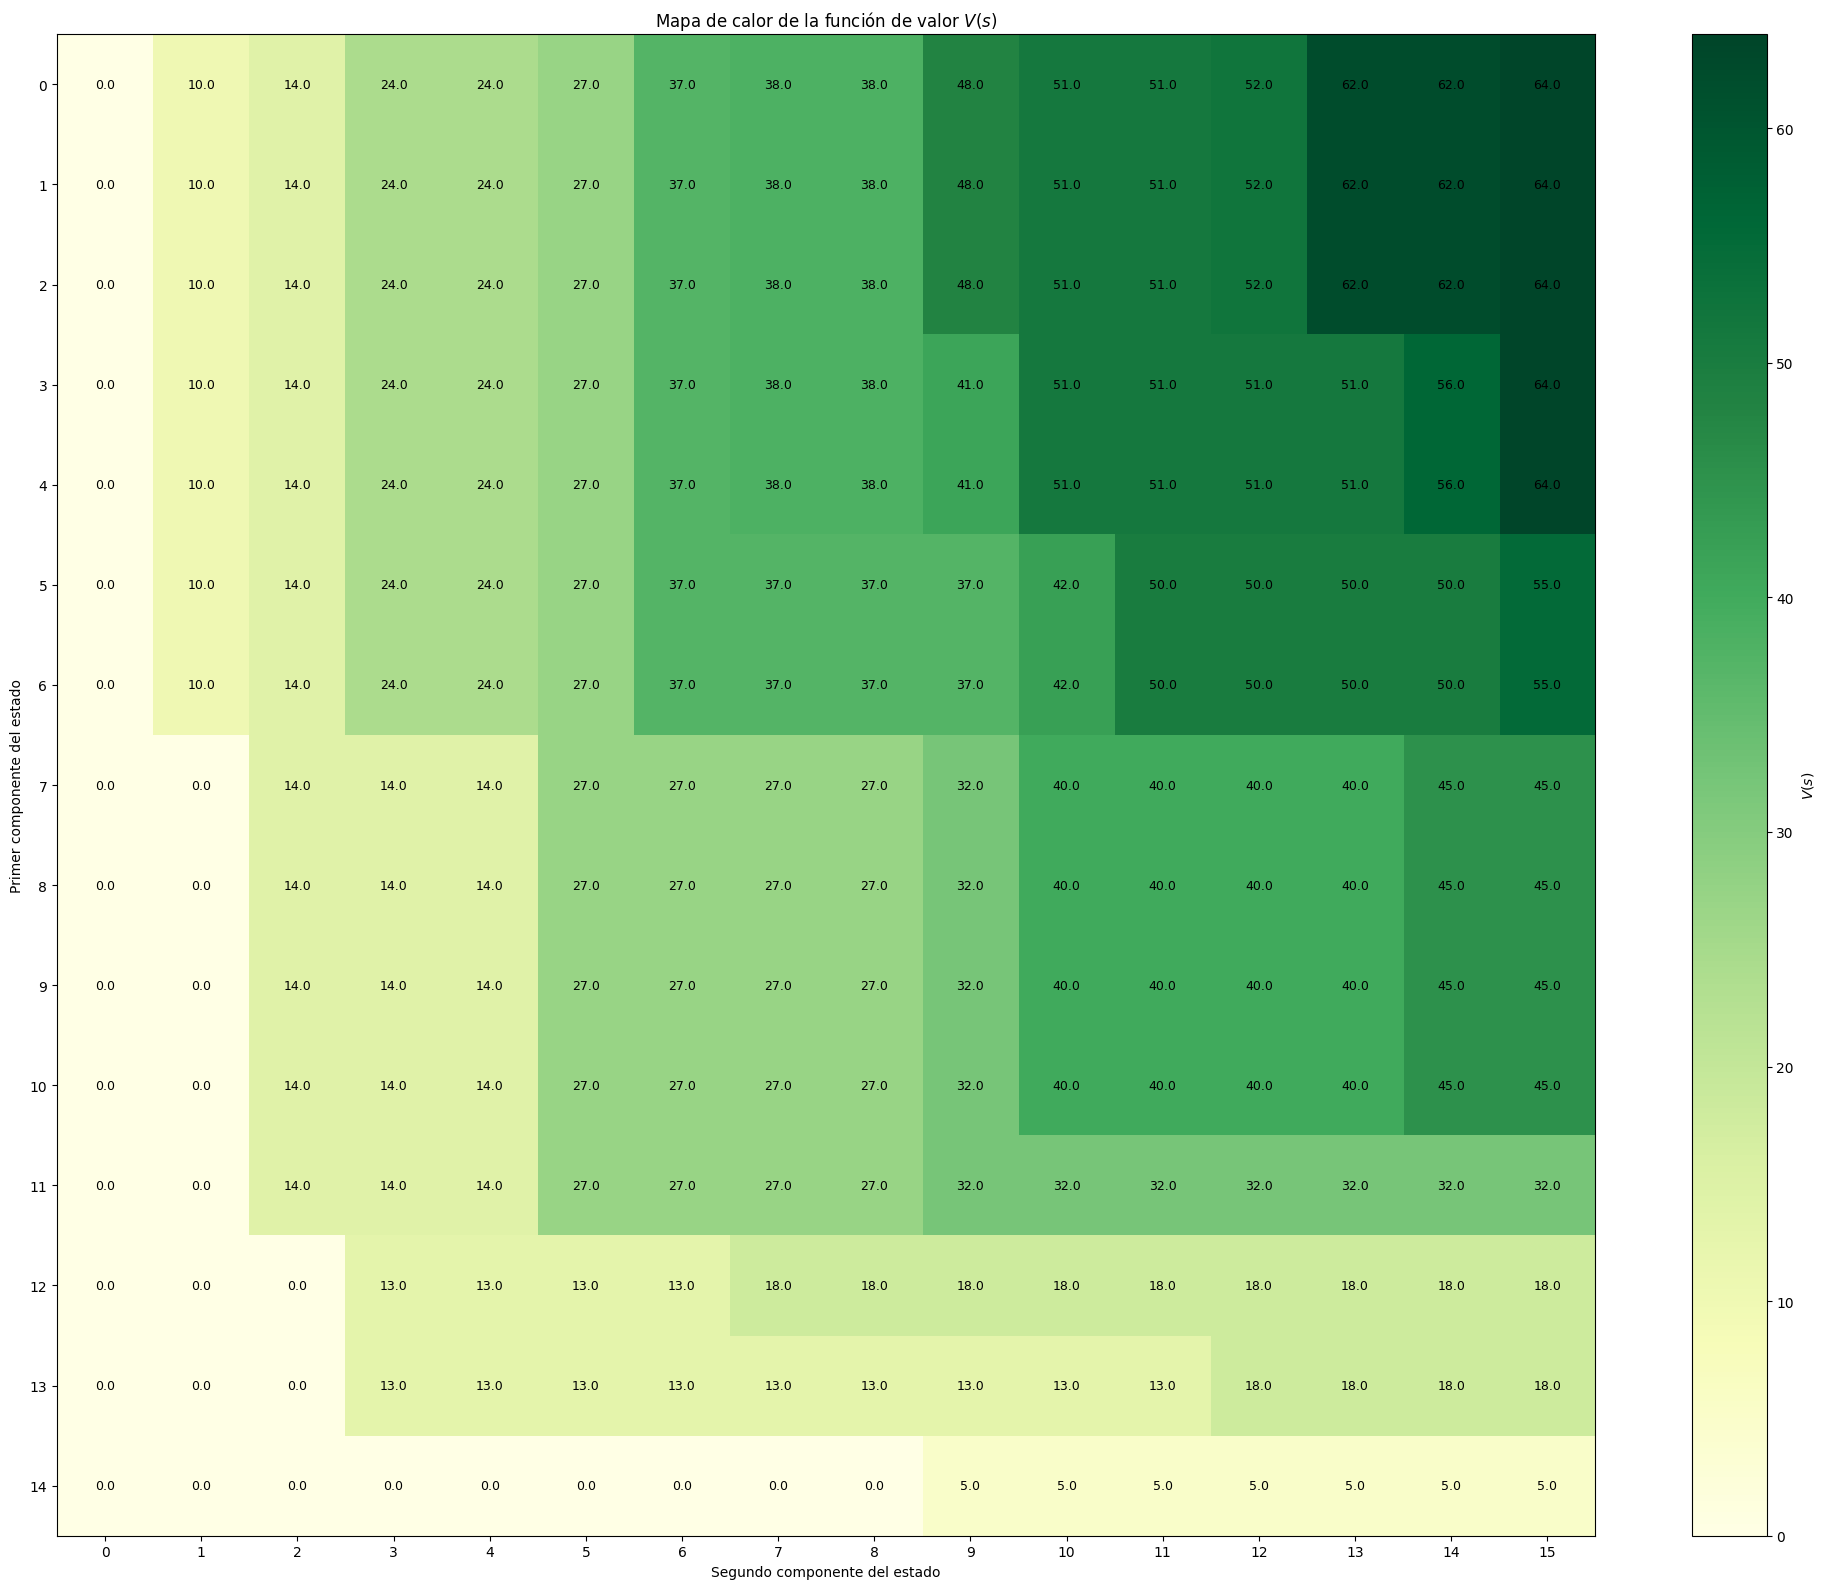

In [10]:
# ============================================================================
# Visualización condicional de V(s) para cada método aplicado
# ============================================================================
# Se muestran mapas de calor solo si el número de ítems (env.n) es razonable.
# Esto evita congestión visual en instancias grandes.
# ============================================================================

if env.n <= 20:

    # ----------------------------------------------------------------------
    # Evaluación de política heurística
    # ----------------------------------------------------------------------
    print("Policy Evaluation")
    value_states_visual(env, V)
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de políticas
    # ----------------------------------------------------------------------
    print("Policy Iteration")
    value_states_visual(env, V_star)
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de valores
    # ----------------------------------------------------------------------
    print("Value Iteration")
    value_states_visual(env, V_opt)
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")


#### Policy

Policy Evaluation


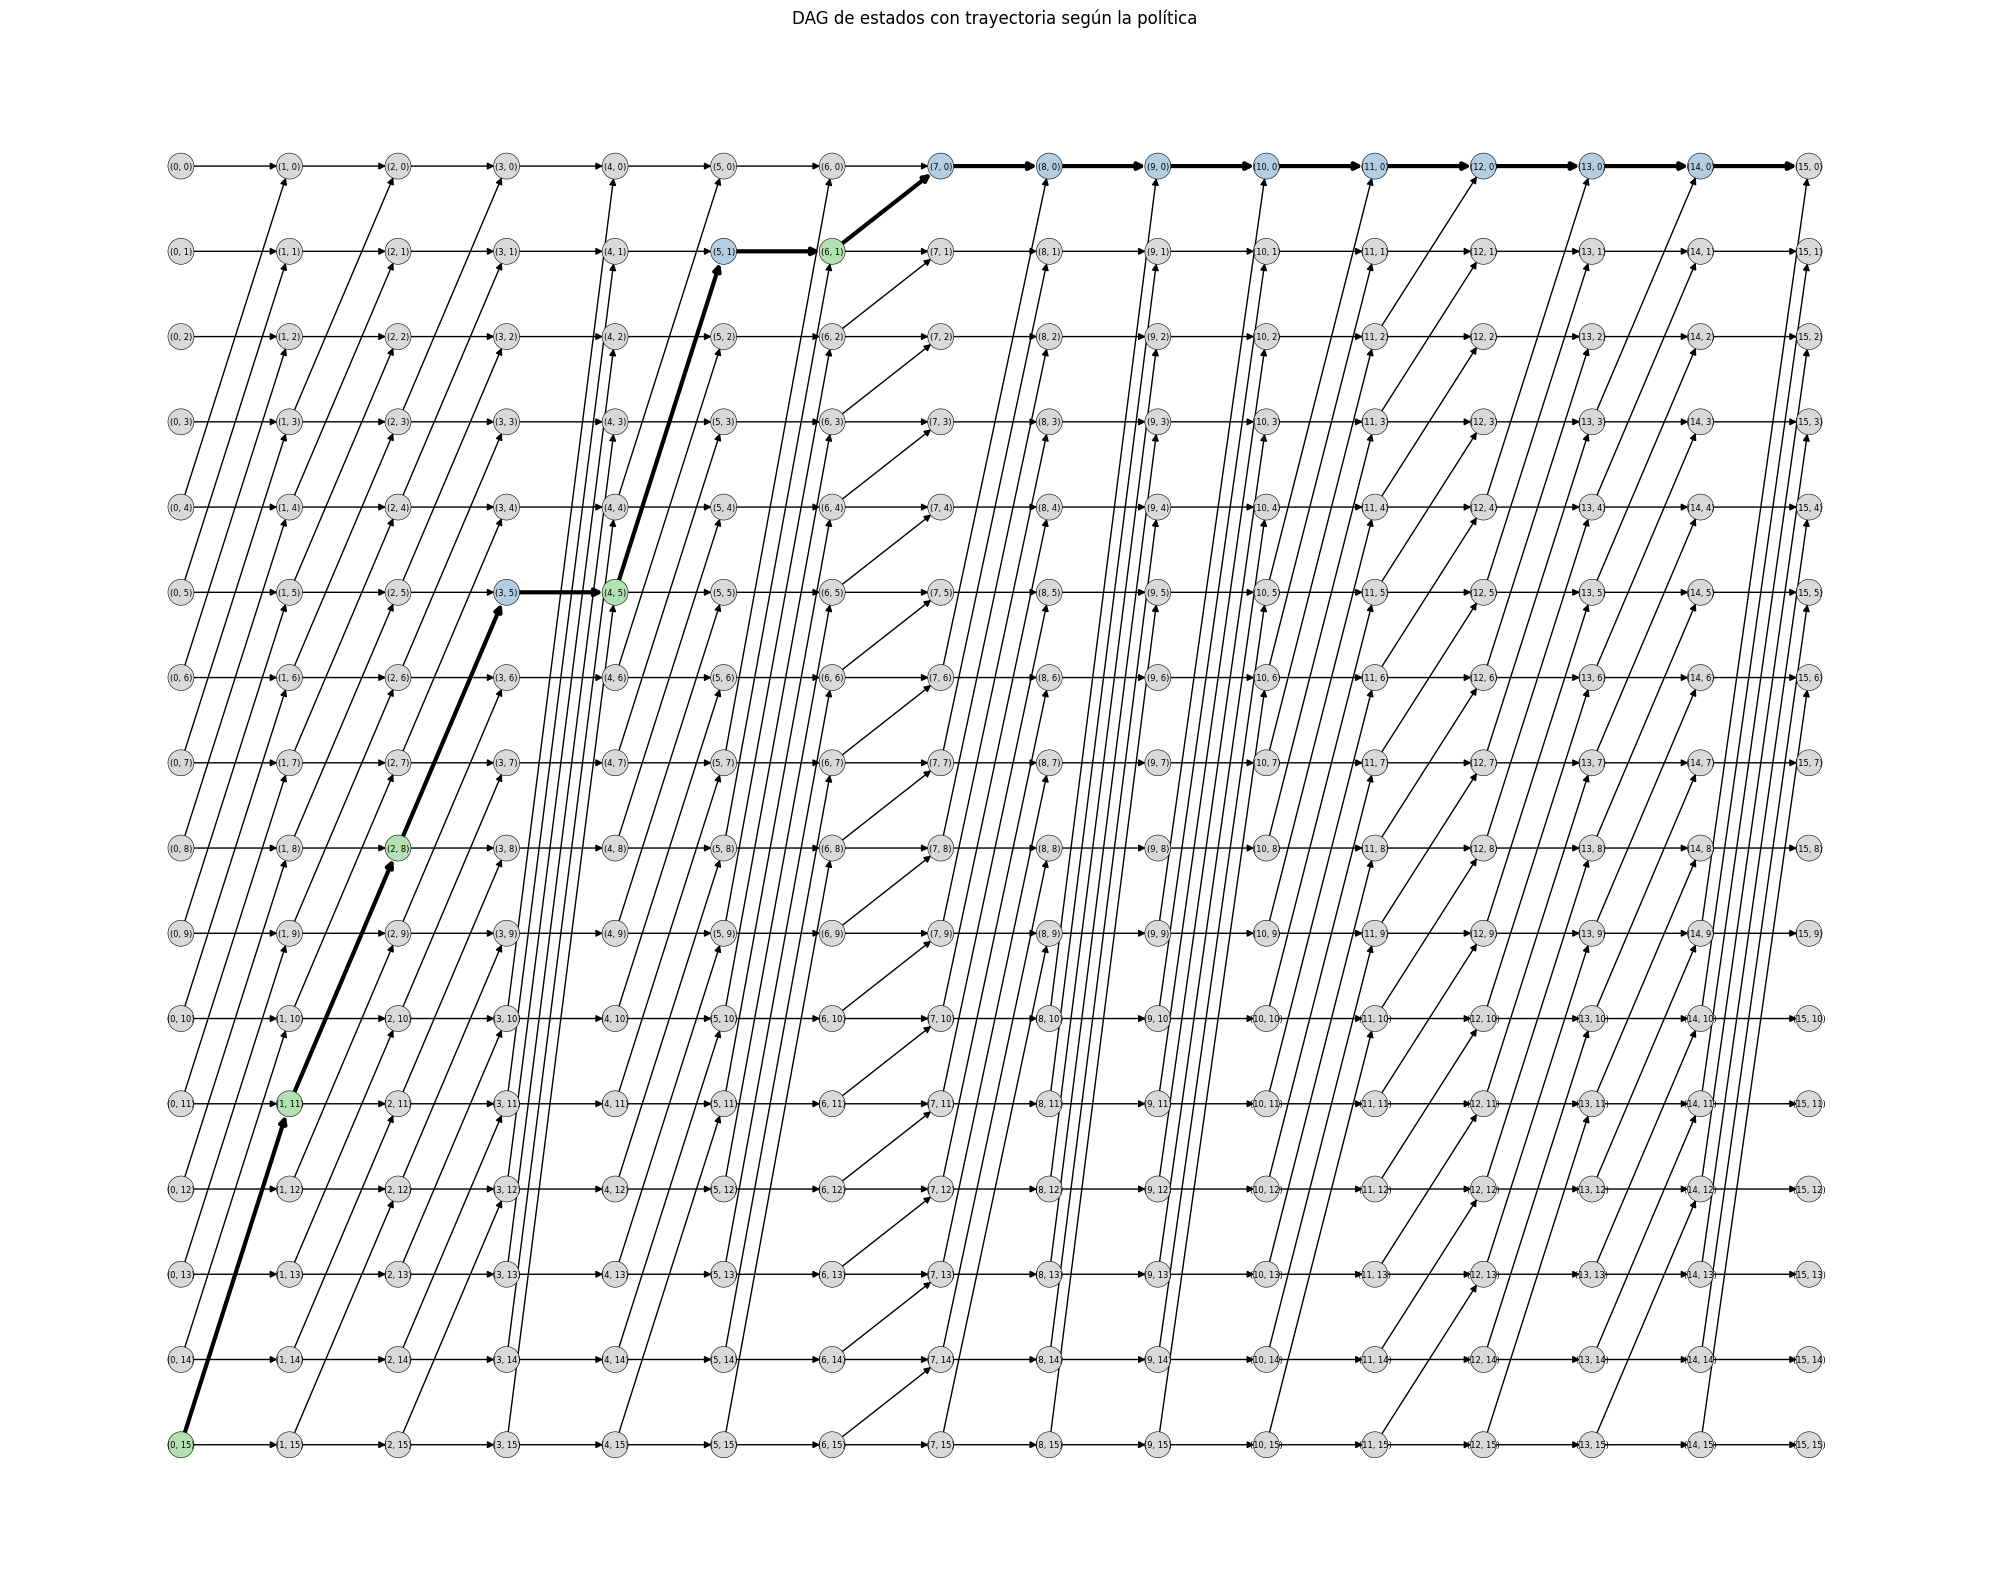


Policy Iteration


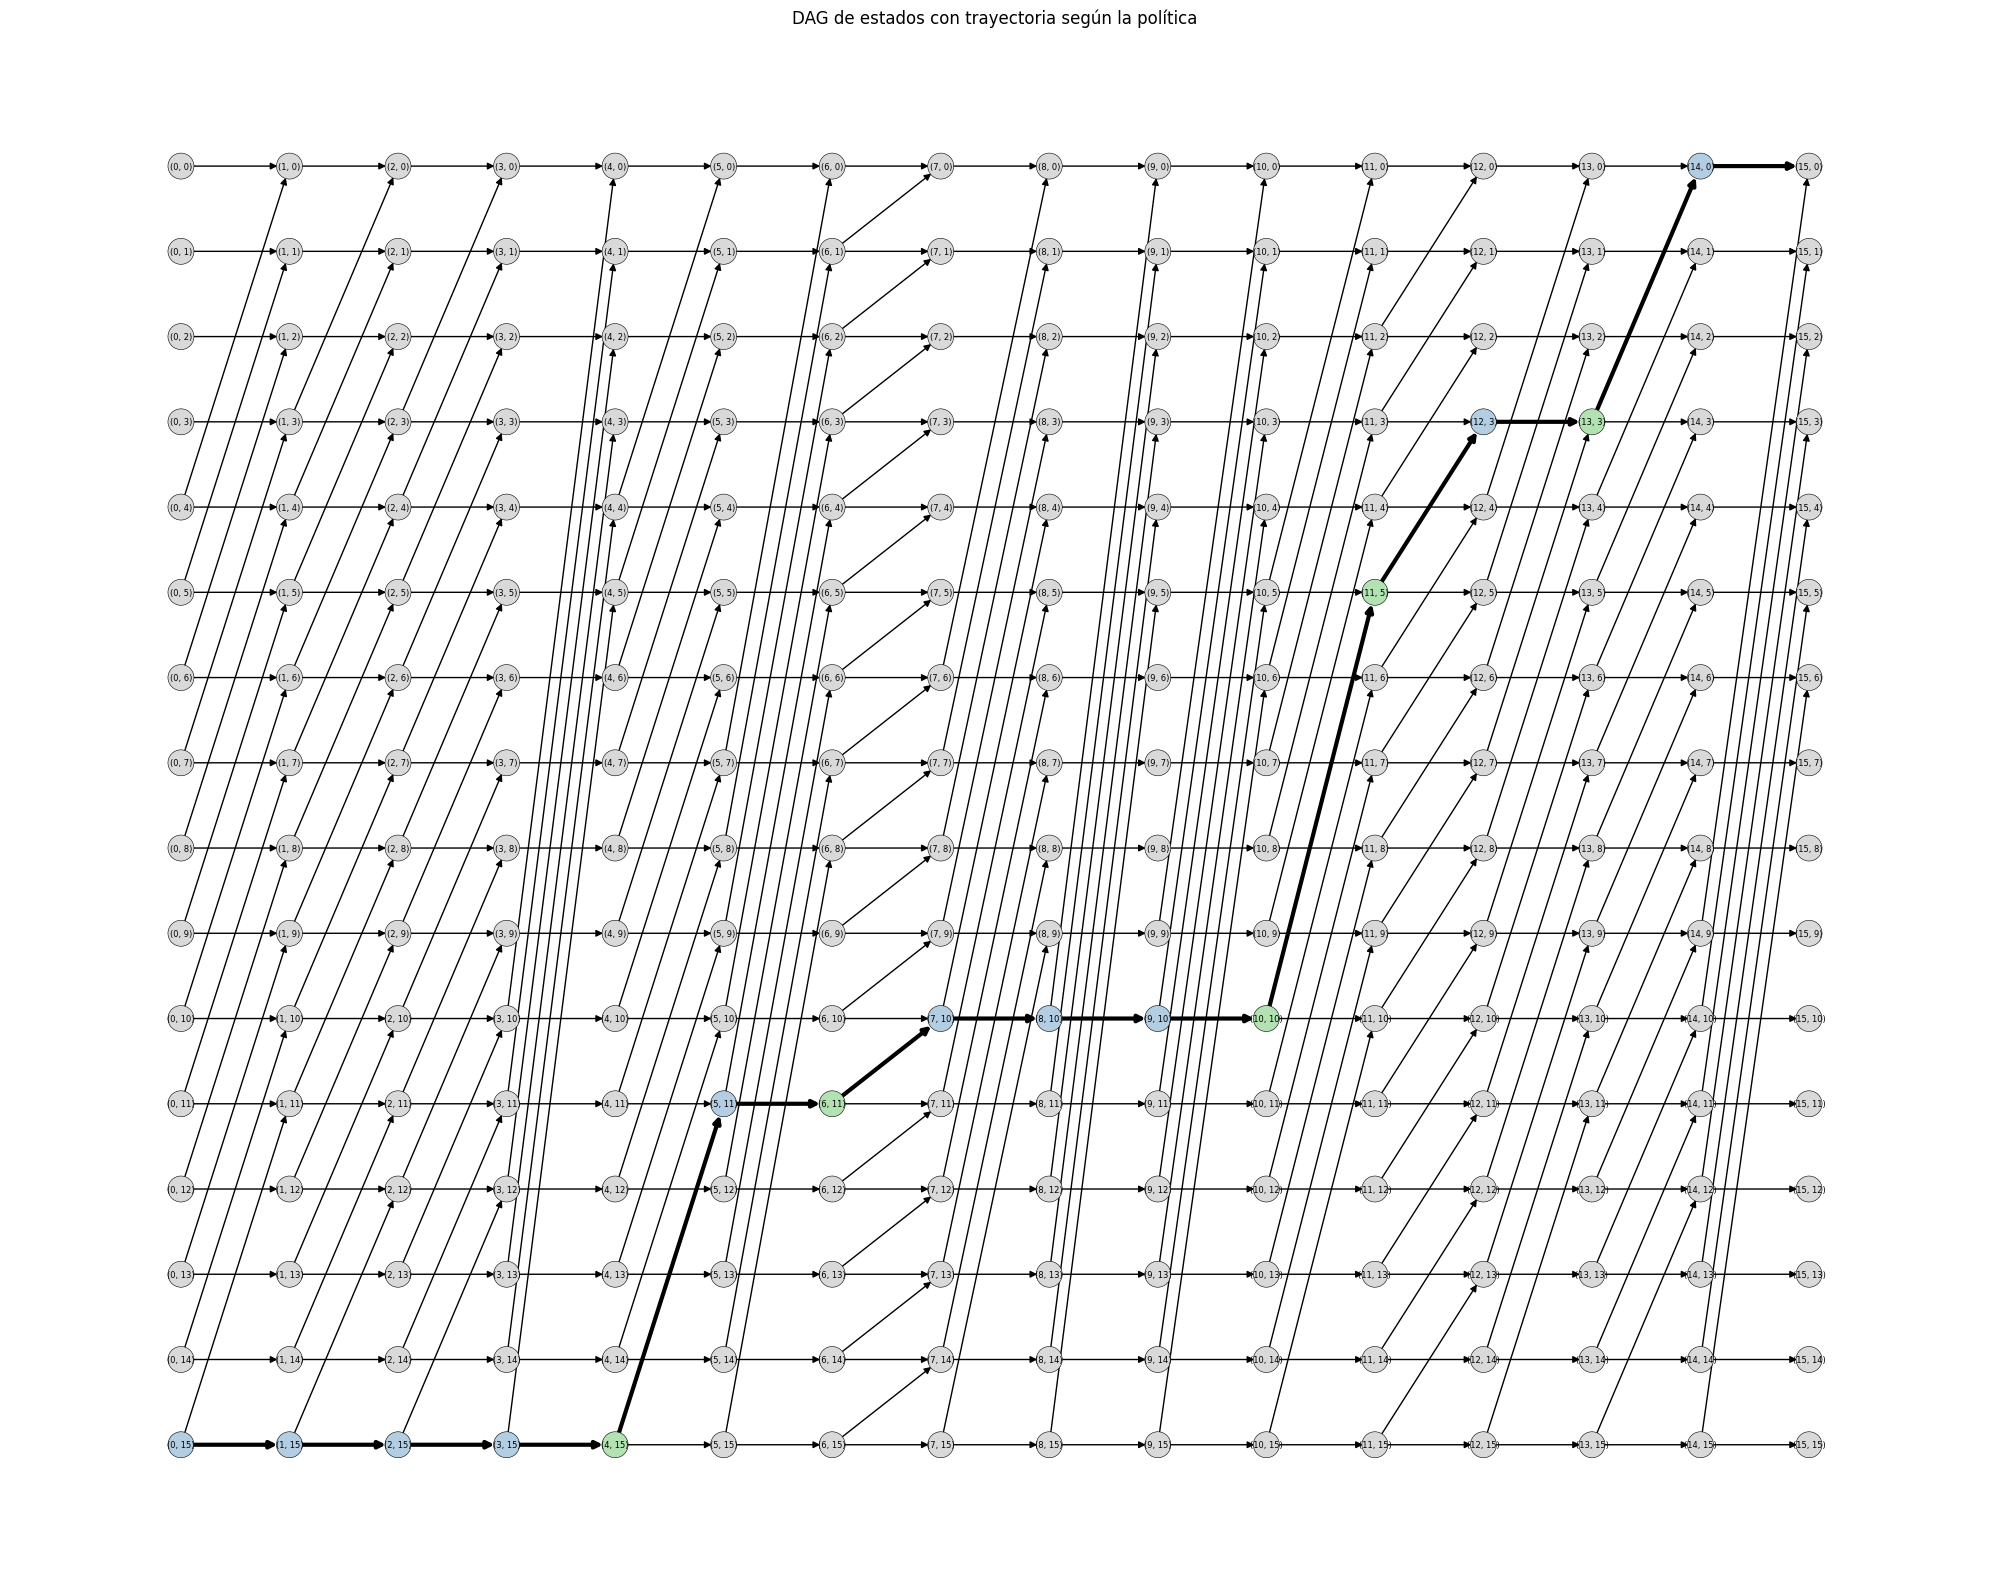


Value Iteration


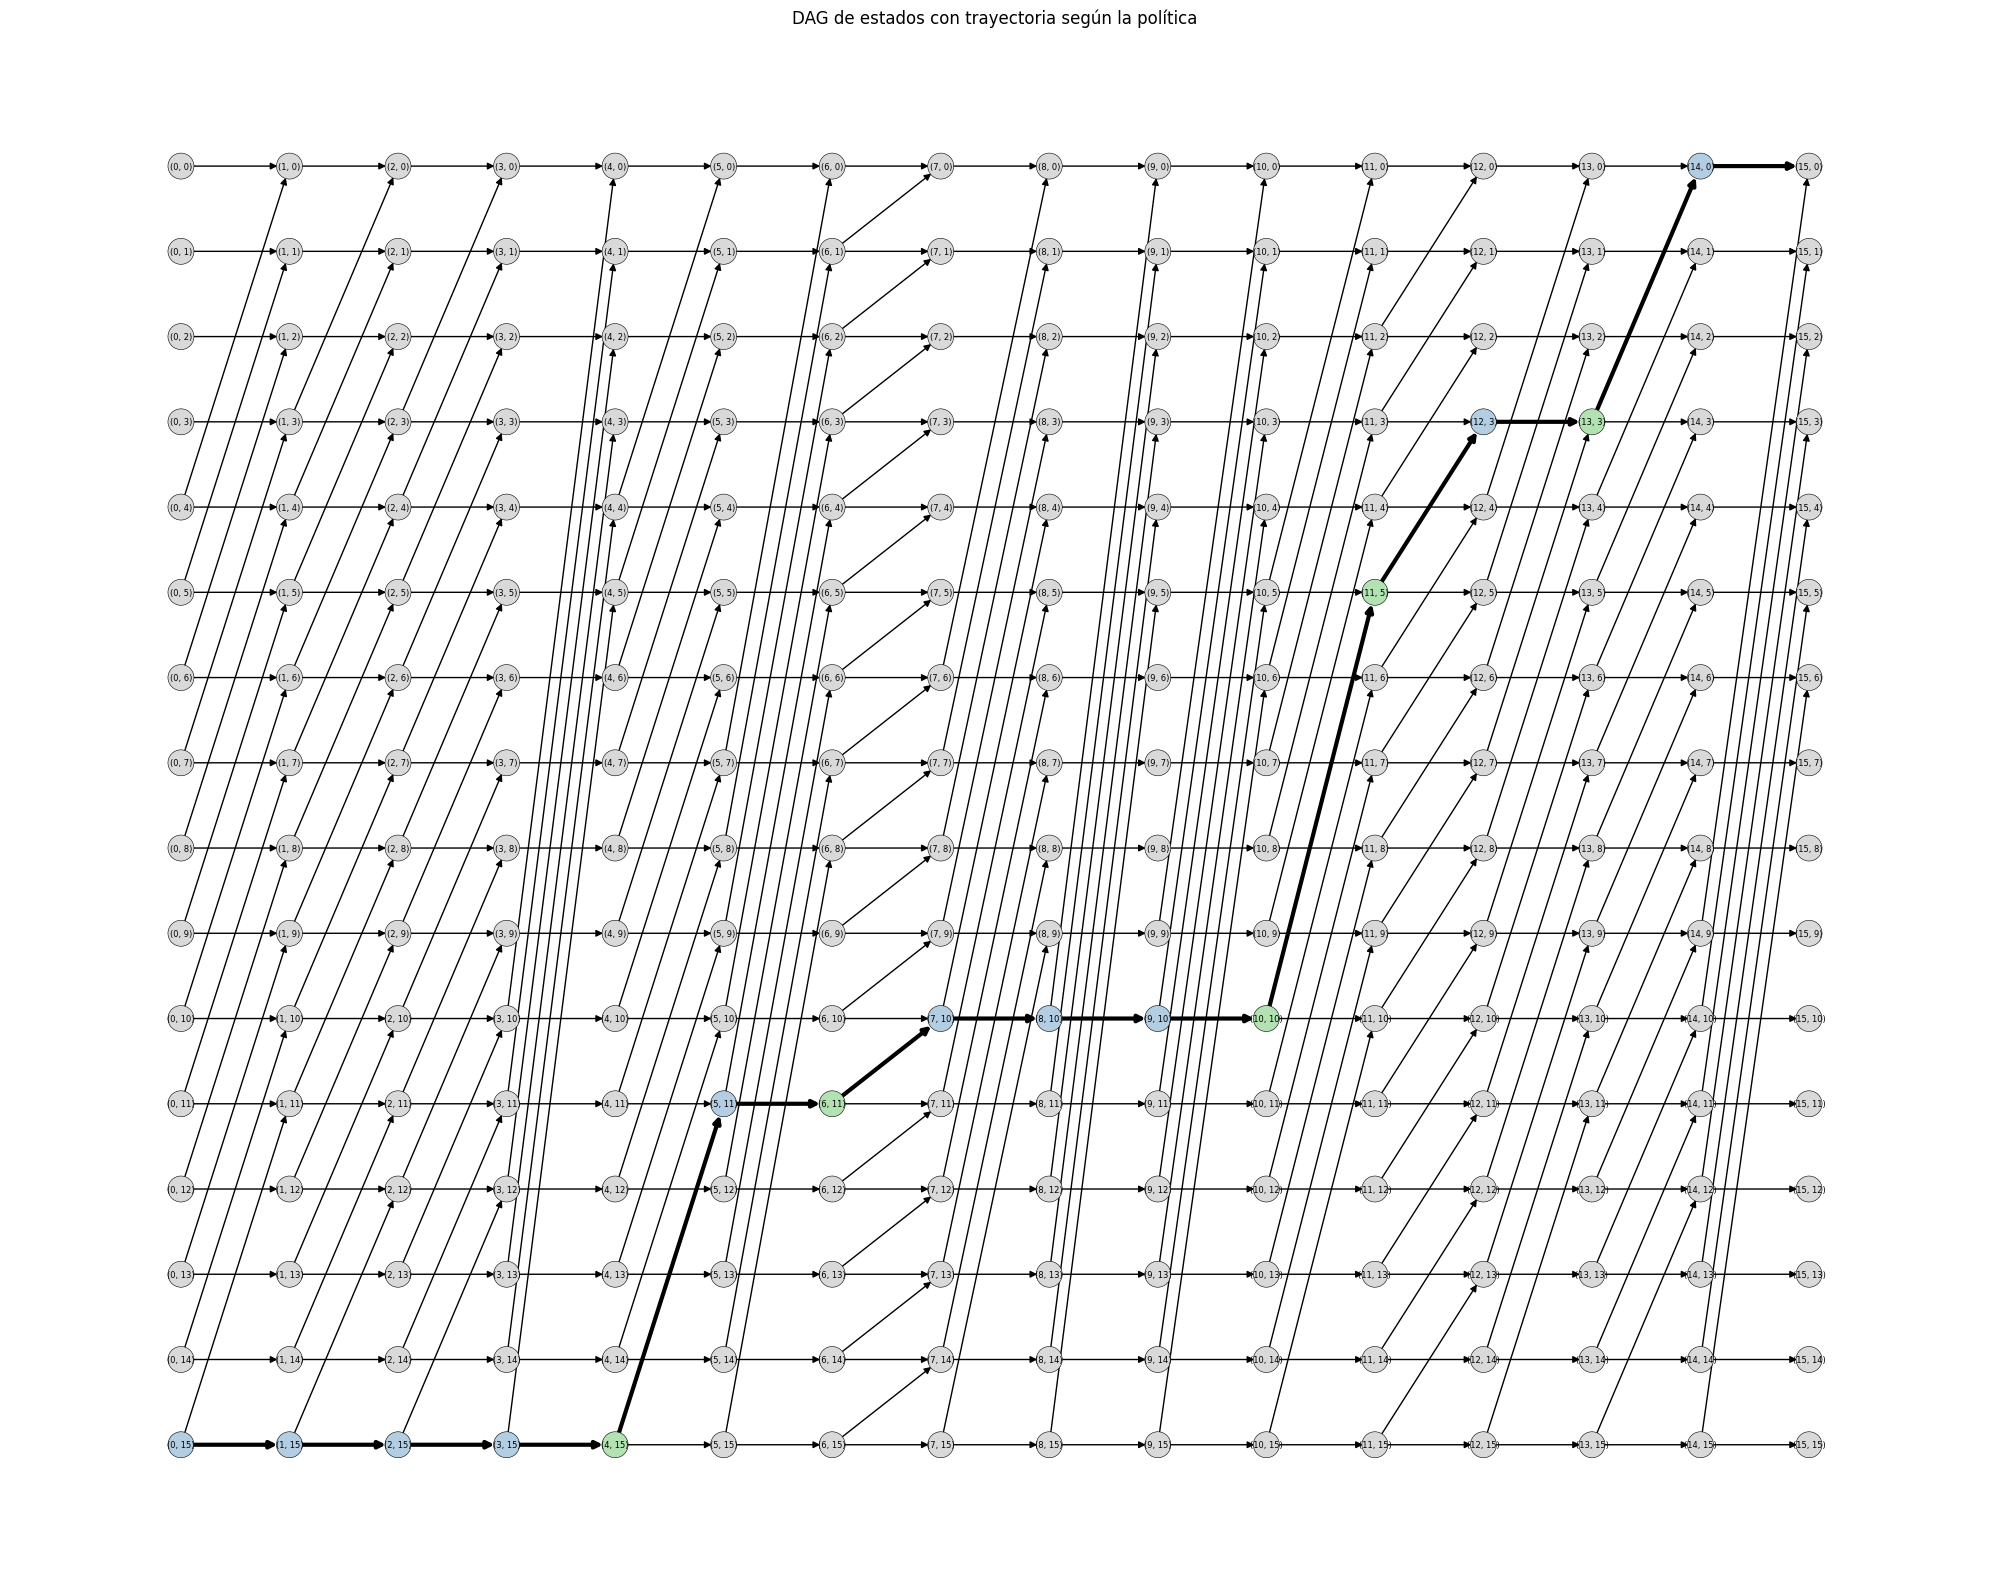

In [11]:
# ============================================================================
# Visualización condicional del DAG de decisiones para cada política evaluada
# ============================================================================
# Dibuja el grafo dirigido de estados con la trayectoria tomada por:
#   • Política heurística
#   • Iteración de políticas
#   • Iteración de valores
# Solo se activa para instancias pequeñas (n ≤ 20).
# ============================================================================

if env.n <= 20:

    # ----------------------------------------------------------------------
    # Política heurística: tomar cuando sea legal
    # ----------------------------------------------------------------------
    print("Policy Evaluation")
    draw_policy_dag(env, propose_policy, initial_state=(0, env.capacity))
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de políticas
    # ----------------------------------------------------------------------
    print("Policy Iteration")
    draw_policy_dag(env, star_policy, initial_state=(0, env.capacity))
    print()

    # ----------------------------------------------------------------------
    # Política óptima vía iteración de valores
    # ----------------------------------------------------------------------
    print("Value Iteration")
    draw_policy_dag(env, opt_policy, initial_state=(0, env.capacity))
    print()

else:
    print("Para visualizar, use una instancia más pequeña.")


## Heurísticas

### Greedy

Esta función aplica un algoritmo **greedy (voraz)** que selecciona obras públicas ordenadas por la mayor cantidad de empleos generados, siempre que no excedan el presupuesto disponible.

**Entrada**:
- $C$: conjunto de candidatos posibles  
- $es\_factible(sol, c)$: función que determina si agregar el candidato $c$ a la solución parcial $sol$ mantiene la factibilidad  
- $criterio(c)$: función que asigna una prioridad a cada candidato $c$  
- $objetivo(sol)$: función que evalúa la calidad de la solución construida $sol$

**Salida**:
- $sol$: conjunto de candidatos seleccionados  
- $valor\_objetivo$: valor de la solución según la función objetivo

**Algoritmo**:

1. Inicializar:  
   $sol \gets \emptyset$

2. Ordenar los candidatos en $C$ en orden decreciente según $criterio(c)$

3. Para cada $c \in C$ en orden:  
   &emsp;Si $es\_factible(sol, c)$ entonces:  
   &emsp;&emsp;$sol \gets sol \cup \{c\}$

4. Calcular:  
   $valor\_objetivo \gets objetivo(sol)$

5. Retornar:  
   $(sol, valor\_objetivo)$


In [12]:
def greedy_knapsack(O, c, e, p, criterio):
    """
    ============================================================================
    Algoritmo voraz (greedy) para selección de obras públicas bajo presupuesto
    ─────────────────────────────────────────────────────────────────────────────
    Selecciona obras en orden decreciente según un criterio dado, y las incluye
    mientras no se supere el presupuesto total.

    Esta aproximación no garantiza optimalidad, pero es eficiente y útil como base.

    Entradas
      • O : list
              Conjunto de identificadores de obras
      • c : dict[obra → costo]
              Costo de cada obra (en millones de COP)
      • e : dict[obra → empleos]
              Empleos generados por cada obra (en miles)
      • p : float
              Presupuesto total disponible
      • criterio : dict[obra → float]
              Métrica para priorizar la selección (ej. e[i]/c[i], e[i], etc.)

    Salida
      • obj_greedy               : empleos generados (miles)
      • obras_selec_greedy      : lista de obras seleccionadas
      • presupuesto_usado_greedy: millones de COP utilizados
    ============================================================================
    """

    # -------------------------------------------------------------------------
    # 1. INICIALIZACIÓN
    # -------------------------------------------------------------------------
    presupuesto_actual = 0.0
    obras_selec_greedy = []

    # -------------------------------------------------------------------------
    # 2. ORDENAR OBRAS SEGÚN EL CRITERIO ESPECIFICADO
    # -------------------------------------------------------------------------
    obras_ordenadas = sorted(O, key=lambda i: criterio[i], reverse=True)

    # -------------------------------------------------------------------------
    # 3. SELECCIÓN VORAZ: agregar mientras no se supere el presupuesto
    # -------------------------------------------------------------------------
    for i in obras_ordenadas:
        if presupuesto_actual + c[i] <= p:
            obras_selec_greedy.append(i)
            presupuesto_actual += c[i]

    # -------------------------------------------------------------------------
    # 4. RESULTADOS: empleos generados y presupuesto utilizado
    # -------------------------------------------------------------------------
    obj_greedy = round(sum(e[i] for i in obras_selec_greedy), 2)
    presupuesto_usado_greedy = round(presupuesto_actual, 2)

    return obj_greedy, obras_selec_greedy, presupuesto_usado_greedy


In [13]:
# ============================================================================
# Ejecución del algoritmo greedy (voraz) bajo criterio de impacto absoluto (e)
# ============================================================================
# Se priorizan las obras que generan más empleos en términos absolutos.
# Se mide tiempo de ejecución y se registran los resultados.
# ============================================================================

# --------------------------------------------------------------------------
# 1. MEDIR TIEMPO DE EJECUCIÓN
# --------------------------------------------------------------------------
start = time.perf_counter()

# ▸ Criterio: empleos absolutos
criterio = e

# ▸ Ejecutar algoritmo voraz
obj_greedy, obras_selec_greedy, presupuesto_usado_greedy = greedy_knapsack(O, c, e, p, criterio)

end = time.perf_counter()

# ▸ Reporte por consola
print(f"Tiempo (s): {end - start:.8f}")
print(f'La cantidad de empleos generados es de: {obj_greedy} (en miles).')
print(f'La cantidad de obras seleccionadas fue de: {len(obras_selec_greedy)}.')
print(f'El presupuesto usado fue (COP Millones): {presupuesto_usado_greedy}/{p}')

# --------------------------------------------------------------------------
# 2. ALMACENAR RESULTADOS EN LISTA DE REPORTE
# --------------------------------------------------------------------------
resultados.append({
    "Método"             : "Greedy (e)",
    "Empleos generados"  : obj_greedy,
    "Obras seleccionadas": len(obras_selec_greedy),
    "Presupuesto usado"  : presupuesto_usado_greedy,
    "Tiempo (s)"         : end - start
})


Tiempo (s): 0.00006350
La cantidad de empleos generados es de: 64.0 (en miles).
La cantidad de obras seleccionadas fue de: 5.
El presupuesto usado fue (COP Millones): 15.0/15


In [14]:
# ============================================================================
# Ejecución del algoritmo greedy (voraz) bajo criterio eficiencia e/c
# ============================================================================
# Se priorizan las obras con mayor impacto por unidad de costo.
# Se mide tiempo de ejecución y se registran los resultados.
# ============================================================================

# --------------------------------------------------------------------------
# 1. MEDIR TIEMPO DE EJECUCIÓN
# --------------------------------------------------------------------------
start = time.perf_counter()

# ▸ Definir criterio: eficiencia = empleos por unidad de costo
criterio = {i: e[i] / c[i] for i in O}

# ▸ Ejecutar algoritmo voraz
obj_greedy, obras_selec_greedy, presupuesto_usado_greedy = greedy_knapsack(O, c, e, p, criterio)

end = time.perf_counter()

# ▸ Reporte por consola
print(f"Tiempo (s): {end - start:.8f}")
print(f'La cantidad de empleos generados es de: {obj_greedy} (en miles).')
print(f'La cantidad de obras seleccionadas fue de: {len(obras_selec_greedy)}.')
print(f'El presupuesto usado fue (COP Millones): {presupuesto_usado_greedy}/{p}')

# --------------------------------------------------------------------------
# 2. ALMACENAR RESULTADOS EN LISTA DE REPORTE
# --------------------------------------------------------------------------
resultados.append({
    "Método"             : "Greedy (e/c)",
    "Empleos generados"  : obj_greedy,
    "Obras seleccionadas": len(obras_selec_greedy),
    "Presupuesto usado"  : presupuesto_usado_greedy,
    "Tiempo (s)"         : end - start
})


Tiempo (s): 0.00018338
La cantidad de empleos generados es de: 62.0 (en miles).
La cantidad de obras seleccionadas fue de: 5.
El presupuesto usado fue (COP Millones): 13.0/15


### Random

Esta función implementa una estrategia aleatoria para seleccionar obras públicas bajo un presupuesto dado. Las obras se mezclan aleatoriamente y se seleccionan en ese orden si hay presupuesto disponible.

**Entrada**:
- $C$: conjunto de candidatos posibles  
- $es\_factible(sol, c)$: función que determina si agregar el candidato $c$ a la solución parcial $sol$ mantiene la factibilidad  
- $objetivo(sol)$: función que evalúa la calidad de la solución construida $sol$

**Salida**:
- $sol$: conjunto de candidatos seleccionados  
- $valor\_objetivo$: valor de la solución según la función objetivo

**Algoritmo**:

1. Inicializar:  
   $sol \gets \emptyset$

2. Generar una permutación aleatoria de los candidatos en $C$:  
   $C_{rand} \gets$ permutación aleatoria de $C$ sin reemplazo

3. Para cada $c \in C_{rand}$:  
   &emsp;Si $es\_factible(sol, c)$ entonces:  
   &emsp;&emsp;$sol \gets sol \cup \{c\}$

4. Calcular:  
   $valor\_objetivo \gets objetivo(sol)$

5. Retornar:  
   $(sol, valor\_objetivo)$


In [15]:
import random

def random_knapsack(O, c, e, p):
    """
    ============================================================================
    Heurística aleatoria para selección de obras bajo restricción presupuestal
    ─────────────────────────────────────────────────────────────────────────────
    Selecciona obras en orden aleatorio (sin reemplazo) mientras no se supere
    el presupuesto total disponible.

    Esta estrategia no garantiza optimalidad, pero sirve como línea base rápida
    para comparar con algoritmos deterministas.

    Entradas
      • O : list
              Identificadores de obras disponibles
      • c : dict[obra → costo]
              Costo por obra (en millones de COP)
      • e : dict[obra → empleos]
              Empleos generados por cada obra (en miles)
      • p : float
              Presupuesto total disponible
      • report : bool
              Si es True, imprime trazas con resultados

    Salidas
      • obj_rand               : empleos generados (miles)
      • obras_selec_rand      : lista de obras seleccionadas
      • presupuesto_usado_rand: millones de COP utilizados
    ============================================================================
    """

    # -------------------------------------------------------------------------
    # 1. INICIALIZACIÓN
    # -------------------------------------------------------------------------
    presupuesto_actual = 0.0
    obras_selec_rand = []

    # -------------------------------------------------------------------------
    # 2. DESORDENAR OBRAS ALEATORIAMENTE (sin reemplazo)
    # -------------------------------------------------------------------------
    obras_random = random.sample(O, len(O))

    # -------------------------------------------------------------------------
    # 3. SELECCIÓN: agregar obras mientras quepa en el presupuesto
    # -------------------------------------------------------------------------
    for i in obras_random:
        if presupuesto_actual + c[i] <= p:
            obras_selec_rand.append(i)
            presupuesto_actual += c[i]

    # -------------------------------------------------------------------------
    # 4. CÁLCULO DE RESULTADOS
    # -------------------------------------------------------------------------
    obj_rand = round(sum(e[i] for i in obras_selec_rand), 2)
    presupuesto_usado_rand = round(presupuesto_actual, 2)

    return obj_rand, obras_selec_rand, presupuesto_usado_rand


In [16]:
# ============================================================================
# Búsqueda aleatoria intensiva (Random Search) con múltiples repeticiones
# ============================================================================
# Ejecuta múltiples soluciones aleatorias (random_knapsack) y conserva la mejor.
# Esto permite observar el mejor rendimiento posible de una estrategia estocástica.
# ============================================================================

# --------------------------------------------------------------------------
# 1. CONFIGURACIÓN DEL EXPERIMENTO
# --------------------------------------------------------------------------
n_iteraciones      = 1000                    # número total de repeticiones
mejor_obj          = -1                      # valor objetivo máximo observado
mejor_obras        = None                    # lista de obras correspondientes
mejor_presupuesto  = 0.0
mejor_tiempo       = 0.0

start_global = time.perf_counter()           # tiempo total del experimento

# --------------------------------------------------------------------------
# 2. EJECUTAR REPETIDAMENTE LA HEURÍSTICA ALEATORIA
# --------------------------------------------------------------------------
for _ in range(n_iteraciones):
    start = time.perf_counter()

    obj_rand, obras_selec_rand, presupuesto_usado_rand = random_knapsack(O, c, e, p)

    end = time.perf_counter()

    # ▸ Actualizar la mejor solución si se mejora la función objetivo
    if obj_rand > mejor_obj:
        mejor_obj         = obj_rand
        mejor_obras       = obras_selec_rand
        mejor_presupuesto = presupuesto_usado_rand
        mejor_tiempo      = end - start

end_global = time.perf_counter()

# --------------------------------------------------------------------------
# 3. REPORTE POR CONSOLA
# --------------------------------------------------------------------------
print(f'La cantidad de empleos generados es de: {mejor_obj} (en miles).')
print(f'La cantidad de obras seleccionadas fue de: {len(mejor_obras)}.')
print(f'El presupuesto usado fue (COP Millones): {mejor_presupuesto}/{p}')
print(f"Tiempo mejor sol (s): {mejor_tiempo:.8f}")
print(f"Tiempo total (s): {end_global:.8f}")

# --------------------------------------------------------------------------
# 4. REGISTRAR EN LA LISTA DE RESULTADOS
# --------------------------------------------------------------------------
resultados.append({
    "Método"             : f"Random (best of {n_iteraciones})",
    "Empleos generados"  : mejor_obj,
    "Obras seleccionadas": len(mejor_obras),
    "Presupuesto usado"  : mejor_presupuesto,
    "Tiempo (s)"         : mejor_tiempo
})


La cantidad de empleos generados es de: 64.0 (en miles).
La cantidad de obras seleccionadas fue de: 5.
El presupuesto usado fue (COP Millones): 15.0/15
Tiempo mejor sol (s): 0.00000667
Tiempo total (s): 17304.64233858


### Búsqueda Local con Intercambios (Swaps)

Esta función mejora una solución inicial del problema de selección de obras mediante una estrategia de **búsqueda local**. En cada iteración:

- Se elimina una obra seleccionada.
- Se prueba reemplazarla por una obra no seleccionada.
- Si el intercambio **no viola el presupuesto** y **mejora el número de empleos**, se acepta.

**Entrada**:
- $C$: conjunto total de candidatos  
- $costo(i)$: función que retorna el costo del candidato $i$  
- $valor(i)$: función que retorna el valor o beneficio del candidato $i$  
- $C_{max}$: capacidad o presupuesto máximo permitido  
- $sol\_inicial$: conjunto inicial factible de elementos seleccionados  
- $n$: número de intentos de mejora

**Salida**:
- $mejor\_sol$: conjunto de elementos de la mejor solución encontrada  
- $mejor\_valor$: valor asociado a la mejor solución  
- $costo\_final$: costo total de la mejor solución

**Algoritmo**:

1. Inicializar:  
   $mejor\_sol \gets sol\_inicial$  
   $mejor\_valor \gets \sum\limits_{i \in mejor\_sol} valor(i)$

2. Repetir $n$ veces:

   a. Seleccionar aleatoriamente un elemento $i \in mejor\_sol$  
   b. Seleccionar aleatoriamente un elemento $j \in C \setminus mejor\_sol$

   c. Proponer nueva solución:  
   &emsp;$nueva\_sol \gets (mejor\_sol \setminus \{i\}) \cup \{j\}$  
   &emsp;$nuevo\_costo \gets \sum\limits_{k \in nueva\_sol} costo(k)$

   d. Si $nuevo\_costo \leq C_{max}$ entonces:

   &emsp;i. Calcular $nuevo\_valor \gets \sum\limits_{k \in nueva\_sol} valor(k)$

   &emsp;ii. Si $nuevo\_valor > mejor\_valor$ entonces:  
   &emsp;&emsp;$mejor\_sol \gets nueva\_sol$  
   &emsp;&emsp;$mejor\_valor \gets nuevo\_valor$

3. Calcular $costo\_final \gets \sum\limits_{i \in mejor\_sol} costo(i)$

4. Retornar:  
   $(mejor\_sol, mejor\_valor, costo\_final)$


In [17]:
def swaps_knapsack(O, c, e, p, sol_inicial, n=100, report=False):
    """
    ============================================================================
    Búsqueda local por swaps para mejora de soluciones en problema de mochila
    ─────────────────────────────────────────────────────────────────────────────
    Parte de una solución inicial válida y aplica intercambios aleatorios entre
    obras seleccionadas y no seleccionadas, conservando presupuesto y buscando
    mejorar el total de empleos generados.

    Entradas
      • O           : lista de identificadores de todas las obras
      • c           : dict[obra → costo] en millones de COP
      • e           : dict[obra → empleos] generados en miles
      • p           : presupuesto máximo permitido (en millones)
      • sol_inicial : lista de obras seleccionadas (solución válida inicial)
      • n           : número de intentos de mejora (default = 100)
      • report      : si True, imprime detalles de mejoras aceptadas

    Salidas
      • mejor_obj        : total de empleos generados (miles)
      • mejor_sol        : lista de obras seleccionadas en la mejor solución
      • presupuesto_usado: presupuesto total utilizado (millones)
    ============================================================================
    """

    # -------------------------------------------------------------------------
    # 1. INICIALIZAR CON LA SOLUCIÓN INICIAL DADA
    # -------------------------------------------------------------------------
    mejor_sol = sol_inicial.copy()
    mejor_obj = sum(e[i] for i in mejor_sol)

    # -------------------------------------------------------------------------
    # 2. INTENTAR MEJORAR LA SOLUCIÓN MEDIANTE SWAPS ALEATORIOS
    # -------------------------------------------------------------------------
    for inter in range(1, n + 1):

        # ▸ Seleccionar una obra para quitar
        i = random.choice(mejor_sol)

        # ▸ Seleccionar una obra que no esté en la solución
        candidatos = list(set(O) - set(mejor_sol))
        j = random.choice(candidatos)

        # ▸ Proponer nueva solución: swap i → j
        nueva_sol = mejor_sol.copy()
        nueva_sol.remove(i)
        nueva_sol.append(j)

        # ▸ Calcular el costo total de la nueva solución
        costo = sum(c[k] for k in nueva_sol)

        # ▸ Verificar si respeta el presupuesto
        if costo <= p:

            # ▸ Calcular empleos generados por la nueva solución
            obj = sum(e[k] for k in nueva_sol)

            # ▸ Aceptar mejora si aumenta empleos
            if obj > mejor_obj:
                if report:
                    print(f'[Intento {inter}] Mejora aleatoria:')
                    print(f'  - Swap: {i} ➜ {j} (e: {e[i]} ➜ {e[j]}, c: {c[i]} ➜ {c[j]})')
                    print(f'  - Objetivo nuevo: {round(obj, 2)}')
                    print(f'  - Presupuesto: {round(costo, 2)}/{p}\n')

                mejor_sol, mejor_obj = nueva_sol, obj

    # -------------------------------------------------------------------------
    # 3. RESULTADO FINAL: REPORTAR MEJOR SOLUCIÓN ENCONTRADA
    # -------------------------------------------------------------------------
    presupuesto_usado = sum(c[i] for i in mejor_sol)

    print(f'Empleos generados: {round(mejor_obj, 2)} mil')
    print(f'Obras seleccionadas: {len(mejor_sol)}')
    print(f'Presupuesto usado: {round(presupuesto_usado, 2)}/{p}')

    return mejor_obj, mejor_sol, presupuesto_usado

In [18]:
# ============================================================================
# Mejora de la mejor solución aleatoria mediante búsqueda local por swaps
# ============================================================================
# Se parte de la mejor solución aleatoria (obras_selec_rand) y se intenta
# mejorar su desempeño aplicando intercambios aleatorios válidos.
# ============================================================================

# --------------------------------------------------------------------------
# 1. DEFINIR SOLUCIÓN INICIAL (punto de partida)
# --------------------------------------------------------------------------
obj_rand, obras_selec_rand, presupuesto_usado_rand = random_knapsack(O, c, e, p)
sol_inicial = obras_selec_rand

# --------------------------------------------------------------------------
# 2. MEDIR TIEMPO DE EJECUCIÓN
# --------------------------------------------------------------------------
start = time.perf_counter()

# ▸ Ejecutar búsqueda local (hasta 10,000 intentos de mejora)
obj_rand_swaps, obras_selec_rand_swaps, presupuesto_usado_rand_swaps = swaps_knapsack(
    O, c, e, p, sol_inicial, n=10_000, report=False
)

end = time.perf_counter()

# ▸ Reporte por consola
print(f"Tiempo (s): {end - start:.8f}")

# --------------------------------------------------------------------------
# 3. REGISTRAR RESULTADOS EN LA LISTA DE MÉTODOS
# --------------------------------------------------------------------------
resultados.append({
    "Método"             : "Random + Swaps",
    "Empleos generados"  : obj_rand_swaps,
    "Obras seleccionadas": len(obras_selec_rand_swaps),
    "Presupuesto usado"  : presupuesto_usado_rand_swaps,
    "Tiempo (s)"         : end - start
})


Empleos generados: 41.0 mil
Obras seleccionadas: 3
Presupuesto usado: 11.0/15
Tiempo (s): 0.01153775


## Resultados

In [19]:
import pandas as pd

# -- Crear DataFrame desde la lista de resultados --
df_resultados = pd.DataFrame(resultados)

# -- Establecer 'Método' como índice --
df_resultados.set_index("Método", inplace=True)

# -- Ordenar por empleos generados (de mayor a menor) --
df_resultados.sort_values("Empleos generados", ascending=False, inplace=True)

# -- Visualizar resultados ordenados --
df_resultados

,Empleos generados,Obras seleccionadas,Presupuesto usado,Tiempo (s)
Método,,,,
LP,64.0,5,15.0,0.085640
Policy iteration,64.0,5,15.0,0.009288
Value iteration,64.0,5,15.0,0.005194
Greedy (e),64.0,5,15.0,0.000063
Random (best of 1000),64.0,5,15.0,0.000007
Greedy (e/c),62.0,5,13.0,0.000183
Policy evaluation,48.0,5,15.0,0.002304
Random + Swaps,41.0,3,11.0,0.011538


In [20]:
# -- Tomar la solución base de referencia (LP) --
base_lp = df_resultados.loc["LP"]

# -- Calcular el GAP porcentual relativo al método LP (excepto para Tiempo) --
gap_df = ((df_resultados - base_lp) / base_lp) * 100

# -- Reemplazar la columna de tiempo con "x veces LP" en lugar de porcentaje --
tiempo_ratio = (df_resultados["Tiempo (s)"] / base_lp["Tiempo (s)"]).round(4)

# -- Redondear GAPs a 3 decimales --
gap_df = gap_df.round(3)

# -- Renombrar columnas GAP --
gap_df.columns = [col + " GAP (%)" for col in gap_df.columns]

# -- Reemplazar columna de tiempo con "x veces LP" --
gap_df["Tiempo (s) (x veces LP)"] = tiempo_ratio

# -- Eliminar columna anterior de GAP de tiempo --
gap_df = gap_df.drop(columns=["Tiempo (s) GAP (%)"])

# -- Mostrar tabla --
gap_df

,Empleos generados GAP (%),Obras seleccionadas GAP (%),Presupuesto usado GAP (%),Tiempo (s) (x veces LP)
Método,,,,
LP,0.000,0.0,0.000,1.0000
Policy iteration,0.000,0.0,0.000,0.1085
Value iteration,0.000,0.0,0.000,0.0606
Greedy (e),0.000,0.0,0.000,0.0007
Random (best of 1000),0.000,0.0,0.000,0.0001
Greedy (e/c),-3.125,0.0,-13.333,0.0021
Policy evaluation,-25.000,0.0,0.000,0.0269
Random + Swaps,-35.938,-40.0,-26.667,0.1347


## Teoría

### Instancia de ejemplo — Portafolio de obras públicas

El Ministerio de Transporte desea seleccionar un subconjunto de obras que maximicen el total de empleos generados, respetando un presupuesto máximo de $20$ millones de pesos. A continuación se presentan los datos simulados de 6 proyectos de infraestructura con valores enteros.

#### Datos de entrada

| ID | Ciudad       | Costo ejecución ($c_i$) [millones] | Empleos generados ($e_i$) [miles] | Latitud     | Longitud    |
|----|--------------|------------------------------------|-----------------------------------|-------------|-------------|
| 1  | Bogotá       | 9                                  | 13                                | 4.710989    | -74.072090  |
| 2  | Medellín     | 3                                  | 6                                 | 6.244203    | -75.581215  |
| 3  | Cartagena    | 1                                  | 3                                 | 10.391049   | -75.479426  |
| 4  | Barranquilla | 6                                  | 9                                 | 10.963889   | -74.796387  |
| 5  | Cali         | 10                                 | 15                                | 3.451647    | -76.531985  |
| 6  | Medellín     | 3                                  | 5                                 | 6.243960    | -75.579227  |

#### Parámetros del modelo

- Conjunto de obras disponibles:  
  $O = \{1, 2, 3, 4, 5, 6\}$

- Costo de ejecución de cada obra (en millones):  
  $c = \{c_1 = 9,\; c_2 = 3,\; c_3 = 1,\; c_4 = 6,\; c_5 = 10,\; c_6 = 3\}$

- Empleos generados por cada obra (en miles):  
  $e = \{e_1 = 13,\; e_2 = 6,\; e_3 = 3,\; e_4 = 9,\; e_5 = 15,\; e_6 = 5\}$

- Presupuesto total disponible:  
  $p = 20$

#### Objetivo del problema

Maximizar la cantidad total de empleos generados.


### Policy Evaluation

#### Definición de política

En cada paso del proceso secuencial se decide **tomar** o **saltar** la obra actual.
La política determinista $\pi$ es

$$
\pi(i,b)=
\begin{cases}
\text{take}, & c_i \le b,\\
\text{skip}, & \text{en otro caso},
\end{cases}
$$

donde $i$ es el índice de la obra evaluada y $b$ el presupuesto restante.

#### Espacio de estados

El presupuesto total es **$p = 20$** millones.
Cada estado es la tupla $(i,\,b)$ con

* $i \in \{0,1,2,3,4,5,6\}$ (7 valores)
* $b \in \{0,1,\dots,20\}$ (21 valores)

Número total de estados:

$$
7 \times 21 = 147.
$$

#### Ejemplos corregidos de la política $\pi(s)$

| Ejemplo | Estado $(i,b)$ | Descripción                                                   | Costo $c_i$ | ¿$c_i \le b$? | Acción $\pi(s)$ |
| ------- | -------------- | ------------------------------------------------------------- | ----------- | ------------- | --------------- |
| 1       | $(0,\;20)$     | Primera obra, 20 millones disponibles                         | $c_1 = 9$   | Sí            | **take**        |
| 2       | $(1,\;11)$     | Tras tomar la obra 1, quedan 11 millones                      | $c_2 = 3$   | Sí            | **take**        |
| 3       | $(2,\;8)$      | Tras tomar las obras 1 y 2, quedan 8 millones                 | $c_3 = 1$   | Sí            | **take**        |
| 4       | $(4,\;1)$      | Tras tomar las obras 1–4, queda 1 millón; se evalúa la obra 5 | $c_5 = 10$  | No            | **skip**        |
| 5       | $(5,\;1)$      | Se evalúa la obra 6 con 1 millón restante                     | $c_6 = 3$   | No            | **skip**        |


### Policy Evaluation

Se ilustra el cálculo del valor esperado $V(s)$ de cada estado bajo la política voraz
**“tomar la obra si su costo cabe en el presupuesto restante; de lo contrario, saltarla”.**
Se usa $\gamma = 1$ (sin descuento) y evaluación iterativa con umbral $\theta = 0{.}01$.

#### Iteración 0: inicialización

$V(s) = 0$ para todo estado $(i,b)$.

#### Iteración 1

Se actualiza a lo largo de la trayectoria que genera la política:

| Paso | Estado $s$ | Acción $\pi(s)$ | Recompensa | Siguiente estado $s'$ | $V_{\text{nuevo}}(s) = r + V(s')$ |
| ---- | ---------- | --------------- | ---------- | --------------------- | --------------------------------- |
| 0    | (0, 20)    | take (obra 1)   | 13         | (1, 11)               | 13                                |
| 1    | (1, 11)    | take (obra 2)   | 6          | (2, 8)                | 6                                 |
| 2    | (2, 8)     | take (obra 3)   | 3          | (3, 7)                | 3                                 |
| 3    | (3, 7)     | take (obra 4)   | 9          | (4, 1)                | 9                                 |
| 4    | (4, 1)     | skip (obra 5)   | 0          | (5, 1)                | 0                                 |
| 5    | (5, 1)     | skip (obra 6)   | 0          | (6, 1)†               | 0                                 |

†$(6,b)$ es terminal, $V = 0$.

Valores tras la primera pasada:
$V(5,1)=0,\;V(4,1)=0,\;V(3,7)=9,\;V(2,8)=3,\;V(1,11)=6,\;V(0,20)=13$.

#### Iteración 2

Se propagan los valores recién calculados (solo cambian estados anteriores en la misma trayectoria):

* $V(5,1)=0$
* $V(4,1)=0 + 0 = 0$
* $V(3,7)=9 + 0 = 9$
* $V(2,8)=3 + 9 = 12$
* $V(1,11)=6 + 12 = 18$
* $V(0,20)=13 + 18 = 31$

#### Iteración 3

Los mismos cálculos producen los mismos valores → $\Delta = 0 < \theta$.
**Convergencia alcanzada.**

#### Valor resultante por estado visitado

| Estado $s$ | $V(s)$ (miles de empleos) |
| ---------- | ------------------------- |
| (0, 20)    | **31**                    |
| (1, 11)    | 18                        |
| (2, 8)     | 12                        |
| (3, 7)     | 9                         |
| (4, 1)     | 0                         |
| (5, 1)     | 0                         |
| (6, b)     | 0                         |

Desde el estado inicial la política produce un **valor esperado de 31 000 empleos**.


### Policy Iteration

Se parte de la política **voraz**: “tomar la obra si su costo cabe en el presupuesto”.  El algoritmo alterna **evaluación** y **mejora** hasta que la política ya no cambie.

##### Paso 0 – Política inicial $\pi_0$ (voraz)

$$
\pi_0(i,b)=
\begin{cases}
\text{take}, & c_i\le b\\
\text{skip}, & c_i>b
\end{cases}
$$

##### Iteración 1 – Evaluación de $\pi_0$

Se calcula $V_{\pi_0}(i,b)$ de forma recursiva, tomando siempre la acción indicada por $\pi_0$.
Resultado relevante:

| Estado $(i,b)$ | $V_{\pi_0}(i,b)$ (miles de empleos) |
| -------------- | ----------------------------------- |
| (0, 20)        | **31**                              |
| (1, 20)        | 33                                  |
| (1, 11)        | 18                                  |
| (2, 8)         | 12                                  |
| …              | …                                   |

Valor en el estado inicial: $V_{\pi_0}(0,20)=31$.

##### Iteración 1 – Mejora de la política

Para cada estado se compara **take** versus **skip** usando $V_{\pi_0}$.

| Estado $s$ | $\,\text{take}$         | $\,\text{skip}$      | Mejor acción |
| ---------- | ----------------------- | -------------------- | ------------ |
| (0, 20)    | $13+V_{\pi_0}(1,11)=31$ | $V_{\pi_0}(1,20)=33$ | **skip**     |
| (1, 11)    | $6+V_{\pi_0}(2,8)=18$   | $V_{\pi_0}(2,11)=0$  | take         |
| Los demás  | coinciden con la voraz  | –                    | –            |

$\;\Rightarrow$ La nueva política $\pi_1$ **salta la obra 1** cuando el presupuesto es 20 M y mantiene el resto de decisiones.

##### Iteración 2 – Evaluación de $\pi_1$

Al seguir $\pi_1$:

1. $(0,20)$ → skip → $(1,20)$
2. $(1,20)$ → take obra 2 → $(2,17)$
3. $(2,17)$ → take obra 3 → $(3,16)$
4. $(3,16)$ → take obra 4 → $(4,10)$
5. $(4,10)$ → take obra 5 → $(5,0)$
6. $(5,0)$ → skip → terminal

Suma de recompensas: $6+3+9+15 = 33$.

| Estado $(i,b)$ | $V_{\pi_1}(i,b)$ |
| -------------- | ---------------- |
| (0, 20)        | **33**           |
| (1, 20)        | 33               |
| (2, 17)        | 27               |
| (3, 16)        | 24               |
| (4, 10)        | 15               |
| (5, 0)         | 0                |

##### Iteración 2 – Mejora

Se repite la comparación con $V_{\pi_1}$.  En **todos** los estados la acción sugerida por $\pi_1$ ya es la que maximiza el valor; no se realizan cambios.

**Convergencia alcanzada** → $\pi_\*\equiv\pi_1$.

##### Política óptima y valor final

*Obras seleccionadas desde el estado inicial (0, 20):* **2, 3, 4 y 5**
*Costo total:* $3+1+6+10=20$ M
*Empleos generados:* $6+3+9+15=\mathbf{33\,000}$

| Estado  | Acción óptima                             |
| ------- | ----------------------------------------- |
| (0, 20) | skip                                      |
| (1, 20) | take                                      |
| (2, 17) | take                                      |
| (3, 16) | take                                      |
| (4, 10) | take                                      |
| demás   | take si $c_i\le b$; de lo contrario, skip |

La iteración de política parte de la estrategia voraz (valor 31 000) y converge en dos ciclos a la política óptima (valor 33 000), demostrando cómo la fase de mejora corrige decisiones miopes.


### Value Iteration

El algoritmo de **Value Iteration** aproxima directamente la función de valor óptima $V^{*}$ y, a partir de ella, deriva la política óptima $\pi^{*}$.

#### 1. Inicialización

$$
V_0(i,b)=0\quad\forall\,(i,b)\in\{0,\dots,6\}\times\{0,\dots,20\}.
$$

Ejemplos iniciales: $V_0(0,20)=0,\;V_0(1,11)=0,\dots$

#### 2. Iteración 1

Para cada estado $s=(i,b)$ se aplica

$$
V_1(s)=\max
\bigl\{
e_i+V_0(i+1,b-c_i)\;\text{(take, si }c_i\le b),\;
V_0(i+1,b)\;\text{(skip)}
\bigr\}.
$$

Ejemplos destacados (todos usan $V_0=\!0$):

| Estado $s$ | Acción **take**   | Acción **skip** | $V_1(s)$ |
| ---------- | ----------------- | --------------- | -------- |
| (5, 7)     | $5+0=5$           | $0+0=0$         | **5**    |
| (4, 10)    | $15+0=15$         | $0$             | **15**   |
| (3, 7)     | $9+V_0(4,1)=9$    | $V_0(4,7)=0$    | **9**    |
| (0, 20)    | $13+V_0(1,11)=13$ | $V_0(1,20)=0$   | **13**   |

#### 3. Iteración 2

Se repite el cálculo usando $V_1$ como base.
Ejemplos clave:

| Estado $s$ | **take** (con $V_1$) | **skip** (con $V_1$) | Nuevo $V_2(s)$ |
| ---------- | -------------------- | -------------------- | -------------- |
| (4, 10)    | $15 + V_1(5,0)=15$   | $V_1(5,10)=5$        | **15**         |
| (3, 16)    | $9 + V_1(4,10)=24$   | $V_1(4,16)=15$       | **24**         |
| (2, 17)    | $3 + V_1(3,16)=12$   | $V_1(3,17)=9$        | **12**         |
| (1, 20)    | $6 + V_1(2,17)=18$   | $V_1(2,20)=3$        | **18**         |
| (0, 20)    | $13 + V_1(1,11)=31$  | $V_1(1,20)=6$        | **31**         |

#### 4. Iteración 3 y convergencia

Una tercera pasada con $V_2$ eleva los valores finales:

* $V_3(5, 7)=5$ (sin cambio)
* $V_3(4, 10)=15$
* $V_3(3, 16)=24$
* $V_3(2, 17)=27$
* $V_3(1, 20)=33$
* $V_3(0, 20)=33$

La diferencia global $\max_{s}|V_3(s)-V_2(s)| = 2 < \theta$ ya en la siguiente iteración, por lo que **converge en 3 iteraciones** con $V^{*}(0,20)=33$.

#### 5. Extracción de la política óptima

Para cada estado se elige la acción que maximiza

$$
Q(s,\text{take}) = e_i + V^{*}(i+1,b-c_i),\qquad
Q(s,\text{skip}) = V^{*}(i+1,b).
$$

Estado inicial $(0, 20)$:

* **Skip** → $Q = V^{*}(1,20)=33$
* **Take** → $Q = 13 + V^{*}(1,11)=31$

$\pi^{*}(0,20)=\text{skip}$.
Repitiendo el criterio en los siguientes estados, la política óptima es:

1. **Skip** la obra 1 (Bogotá).
2. **Take** las obras 2, 3, 4 y 5 (Medellín, Cartagena, Barranquilla, Cali).
3. **Skip** la obra 6 (sin presupuesto).

#### 6. Resultado final

| Métrica              | Valor óptimo                |
| -------------------- | --------------------------- |
| Obras seleccionadas  | 2, 3, 4, 5                  |
| Costo total          | 3 + 1 + 6 + 10 = **20 M**   |
| Empleos generados    | 6 + 3 + 9 + 15 = **33 000** |
| $V^{*}(0,20)$        | **33**                      |
| Iteraciones de valor | 3                           |

#### Conclusión

**Value Iteration** llega al mismo resultado que *Policy Iteration* sin fijar una política intermedia: tras tres iteraciones obtiene $V^{*}=33$ mil empleos y una política que invierte todo el presupuesto en las cuatro obras más rentables.


### Greedy

Aplicamos un algoritmo voraz para seleccionar obras públicas bajo la restricción presupuestal de **maximizar los empleos** sin exceder el presupuesto.

#### Paso 1 — Inicialización

* $sol \leftarrow \varnothing$
* $costo_{\text{acum}} \leftarrow 0$

#### Paso 2 — Ordenar por $e_i/c_i$ (de mayor a menor)

Orden resultante: $[3,\;2,\;6,\;4,\;5,\;1]$

#### Paso 3 — Recorrido voraz

| Orden | Obra | Costo | Estado del presupuesto | ¿Se agrega? | Conjunto $sol$ |
| ----- | ---- | ----- | ---------------------- | ----------- | -------------- |
| 1     | 3    | 1     | $0+1=1 \le 20$         | Sí          | {3}            |
| 2     | 2    | 3     | $1+3=4 \le 20$         | Sí          | {3,2}          |
| 3     | 6    | 3     | $4+3=7 \le 20$         | Sí          | {3,2,6}        |
| 4     | 4    | 6     | $7+6=13 \le 20$        | Sí          | {3,2,6,4}      |
| 5     | 5    | 10    | $13+10=23 > 20$        | No          | {3,2,6,4}      |
| 6     | 1    | 9     | $13+9=22 > 20$         | No          | {3,2,6,4}      |

#### Paso 4 — Valor objetivo

Empleos totales:
$e_3 + e_2 + e_6 + e_4 = 3 + 6 + 5 + 9 = 23$ mil

#### Resultado final

* **Obras seleccionadas:** $\{3,\;2,\;6,\;4\}$
* **Presupuesto utilizado:** $13$ millones (quedan 7 millones sin gastar)
* **Empleos generados:** $23$ mil

#### Conclusión

Con un presupuesto de 20 M, el algoritmo voraz deja presupuesto sin usar y no alcanza el máximo posible de empleos (33 mil). En esta instancia, la estrategia greedy **no es óptima**; la solución óptima requiere reconsiderar el orden o aplicar un método exacto como *knapsack*.


### Random

Algoritmo: recorrer las obras en un orden aleatorio y agregar cada una **solo si su costo cabe en el presupuesto restante**.

#### Paso 1 — Inicialización

$sol \leftarrow \varnothing,\quad costo_{\text{acum}} \leftarrow 0$

#### Paso 2 — Permutación aleatoria (ejemplo)

$C_{\text{rand}} = [5,\;1,\;4,\;3,\;6,\;2]$

#### Paso 3 — Construcción de la solución

| Orden | Obra | Costo $c_i$ | Nuevo costo acumulado | ¿Se agrega? | $sol$ resultante |
| ----- | ---- | ----------- | --------------------- | ----------- | ---------------- |
| 1     | 5    | 10          | $0+10 = 10 \le 20$    | Sí          | {5}              |
| 2     | 1    | 9           | $10+9 = 19 \le 20$    | Sí          | {5,1}            |
| 3     | 4    | 6           | $19+6 = 25 > 20$      | No          | {5,1}            |
| 4     | 3    | 1           | $19+1 = 20 \le 20$    | Sí          | {5,1,3}          |
| 5     | 6    | 3           | $20+3 = 23 > 20$      | No          | {5,1,3}          |
| 6     | 2    | 3           | $20+3 = 23 > 20$      | No          | {5,1,3}          |

#### Paso 4 — Valor objetivo

Empleos generados: $e_5 + e_1 + e_3 = 15 + 13 + 3 = 31$ mil

#### Resultado final

* **Obras seleccionadas:** $\{5,\,1,\,3\}$
* **Presupuesto utilizado:** 20 millones (exacto)
* **Empleos generados:** 31 000

Esta solución aleatoria es factible, pero distante del óptimo conocido (33 000 empleos), lo que muestra la variabilidad y posible ineficiencia de la heurística cuando no se aplican mejoras o reinicios múltiples.


### Búsqueda Local con Intercambios (Swaps)

Se parte de la solución aleatoria que alcanzó **31 000 empleos**:
$sol_0 = \{5,\,1,\,3\}$ con costo $10+9+1 = 20$ M y valor $15+13+3 = 31$.

La heurística intenta cinco intercambios aleatorios; en cada intento se sustituye una obra de la solución por otra(s) fuera de ella, siempre que el nuevo conjunto siga siendo factible y ofrezca más empleos.

#### Paso 1 – Solución inicial

| Conjunto    | Costo (M) | Empleos (mil) |
| ----------- | --------- | ------------- |
| $\{5,1,3\}$ | 20        | 31            |

#### Paso 2 – Iteraciones de mejora

| Intento | Obra(s) que salen | Obra(s) que entran | Nuevo conjunto    | Costo (M)       | Empleos (mil)   | ¿Mejora? |
| ------- | ----------------- | ------------------ | ----------------- | --------------- | --------------- | -------- |
| 1       | 1                 | 2, 4               | $\{5,3,2,4\}$     | $10+1+3+6 = 20$ | $15+3+6+9 = 33$ | **Sí**   |
| 2       | 5                 | 1                  | $\{1,3,2,4\}$     | 19              | 31              | No       |
| 3       | 3                 | 6                  | $\{5,1,6,2,4\}$\* | 22              | 34              | Inviable |
| 4       | 4                 | 6                  | $\{5,1,3,2,6\}$\* | 23              | 32              | Inviable |
| 5       | 2                 | 1                  | $\{5,1,3,4\}$     | 26              | 40              | Inviable |

\*Propuesta descartada por exceder el presupuesto de 20 M.

#### Paso 3 – Resultado final

| Mejor conjunto | Costo (M) | Empleos (mil) |
| -------------- | --------- | ------------- |
| $\{2,3,4,5\}$  | 20        | **33**        |

#### Conclusión

La búsqueda local elevó la solución inicial de 31 000 a **33 000 empleos**, alcanzando la combinación óptima dentro del presupuesto. Aunque la técnica no garantiza optimalidad en general, aquí bastó un único intercambio afortunado para mejorar hasta el máximo conocido.
